## Laptop Prices

Data Science Course HIT 2023 | 
Aiden Kaminsky

In this project I web scrap data from Amazon, about laptops. orgenize and clean it, and than put it into machine learning.<br>
I only search for 5 brands, as to have enoghf data on each to make a graphs, those brand are: Apple, HP, Dell, Lenovo and 
ASUS.

Notes:

- about the scraping, I commented the line that starts the scaping so you can to 'Run All' on the cells<br>
other ways the scraping will start and it takes aLONG time, but if you want just un-commnt them, I put a comment to show which line they are

- when saveing to csv I used mode x, to make sure I don't save over a file, so I comment them for the submission.<br>
other ways it will give you a 'bug' (which was intaned for waring me about saveing over files)<br>
I didn't do this on 3 files: urls_search_pages_0_300(Feb_3), prodocts_from_1223_3000(0_100)(7_feb_2023), all_page_data_0_100(6_feb)<br>
Just ignore them, Unless you want to do scraping then the info goes there.

 - note: I make alot of spaling mistacks

# Table Of Content:
- [libraries](#libraries)
- [Part 1 - Scraping the data](#Scraping_data)
    - [Part 1.1 - getting urls from search pages](#Scraping_P1.1)
    - [Part 1.2 - getting prodocts info from urls](#Scraping_P1.2)
- [Part 2 - Cleaning data](#Cleaning_data)
    - [Part 2.1 - reorgnizing data](#Cleaning_data)
    - [Part 2.2 - Missing data](#Missing_data)
    - [Part 2.3 - Outliers](#Outliers_data)
- [Part 3 - EDA](#eda_visualiztion)
- [Part 4 - Machine Learning](#machine_learning)


## <a class="anchor" id="libraries"></a> Libraries

In [1]:
# import libraries
import os
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import pickle
import time
import random
import csv
from csv import DictWriter
import pathlib
import os.path

# for cleaning
import re
import datetime

# for plots
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

# mation learning
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

<span style=background:yellow>
    ---------------------------------------------------------------------------------------------------------------------
</span>

## <a class="anchor" id="Scraping_data"></a> Part 1 - Scraping_data

## <a class="anchor" id="Scraping_P1.1"></a>
Part 1.1 - get prodoct urls from search pages in amazon

I first wanted a list of urls of prodocts (laptops), so I decided to scrap amazon search of laptops,<br>
which have about 30 laptops in a page. it was also easy to find the 'next page' url in a search page.<br>

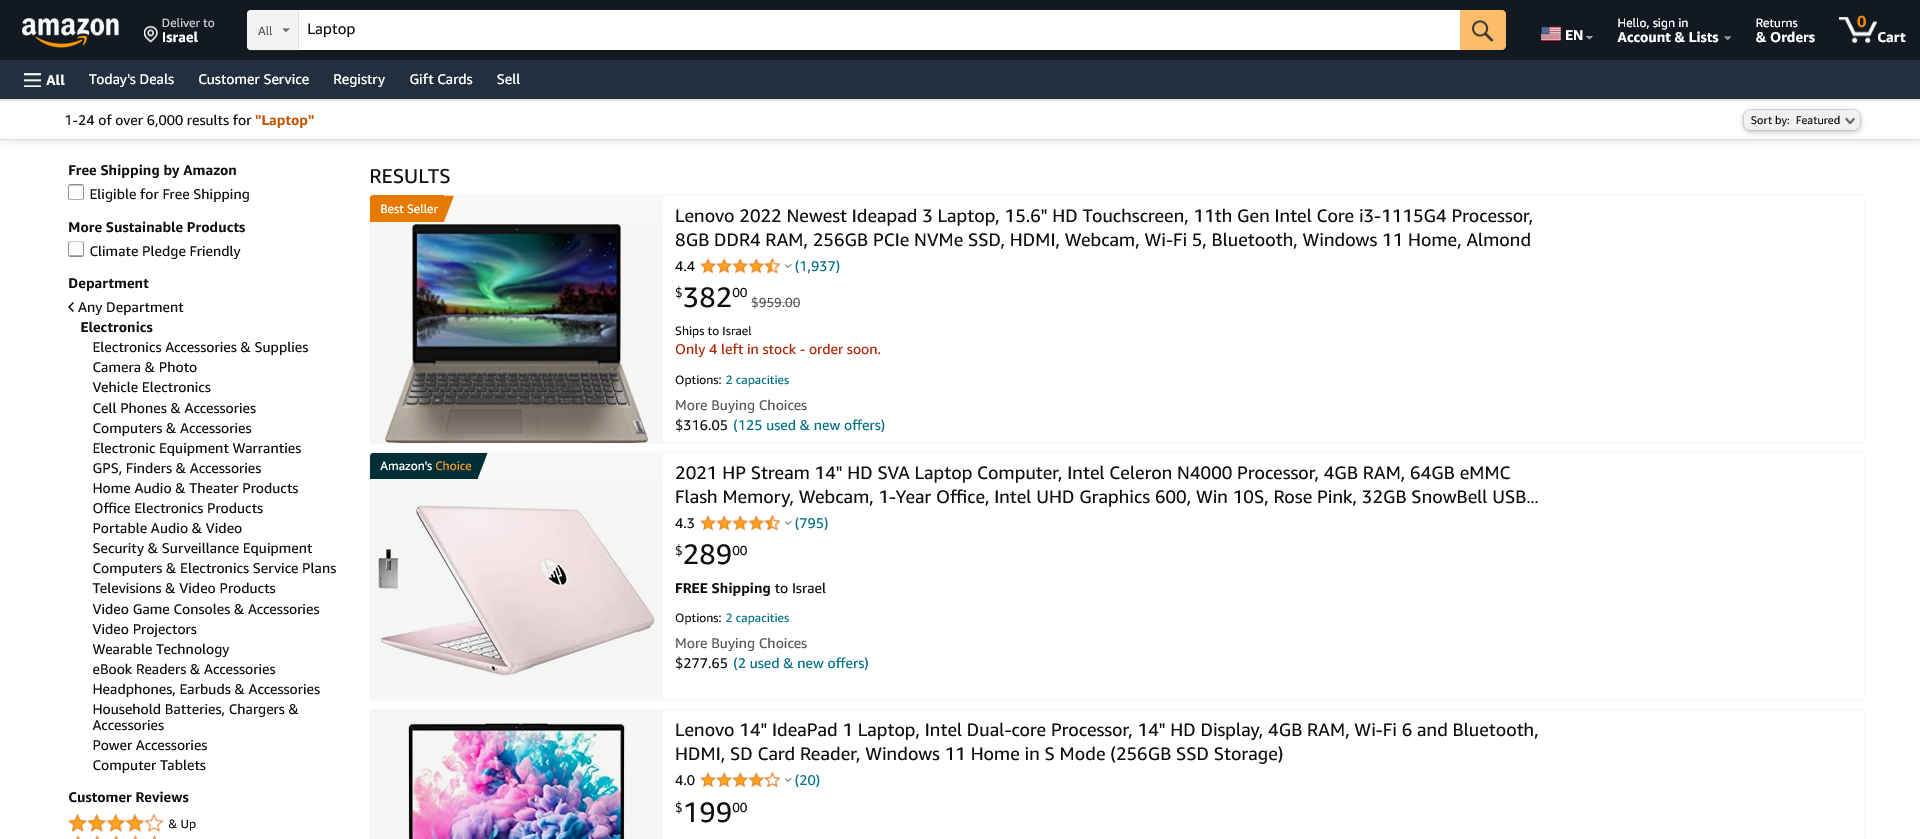

In [2]:
''' --------------- search_page_handler(url, headers) -----------------------
gets: url=the url of the prodoct, headers=the thing needed to get amazon html
return: returns next page url and urls of the prodocts that whore in this search page
goes over the urls in the search page
'''
def search_page_handler(url, headers):
    page = requests.get(url, headers=headers)
    
    soup1 = BeautifulSoup(page.content, 'html.parser')
    soup2 = BeautifulSoup(soup1.prettify(), 'html.parser')
    
    # get prodocts urls
    urls = []
    for h in soup2.find_all("a",{"class":"a-link-normal s-underline-text s-underline-link-text s-link-style a-text-normal"}):
        url_string = h.attrs['href']
        sep = '/ref='
        url_string_stripped = url_string.split(sep, 1)[0]
        result_id = re.search('\w*dp/(.*)', url_string_stripped)
        if(result_id != ''):
            urls.append('https://www.amazon.com' + url_string_stripped)

    # get next page
    next_url = soup2.find("a",{"class":'s-pagination-next'})
    if next_url != None:
        next_url = next_url.get("href")
        next_url = 'https://www.amazon.com' + next_url
    
    return next_url, urls


In [3]:
def put_prodoct_urls_in_csv_from_search_pages(url, headers, pickle_name, csv_name, how_many_pages):
    t_sleep = 10 + random.randint(0, 9) #how many sec to sleep between search pages
    
    for i in range(1, how_many_pages):
        # scrap the search page i (returns the url of next page and prodocts urls)
        next_url, prodocts_urls = search_page_handler(url, headers)
        print('page:', i)
        # put urls in csv
        # Open our existing CSV file in append mode
        with open(csv_name, 'a', encoding='UTF8') as f_object:
            # Pass this file object to csv.writer() and get a writer object
            writer_obj = csv.writer(f_object)
            # Pass the list as an argument into the writerow()
            writer_obj.writerow(prodocts_urls)
            # Close the file object
            f_object.close()
            
        with open(pickle_name, 'ab') as f:
            pickle.dump(prodocts_urls, f)
        
        url = next_url
        if next_url == None:
            break
        t_sleep = 10 + random.randint(0, 9)
        time.sleep(t_sleep) # in secs

Some explantion:<br>
the headers is from a amazon scraping tutoil from the intrnet, that is all I got from it the rest had to do on my own,<br>
becuse they scraped only prodoct pages from amazon (which weren't laptops).<br>
<br>
then I didn't want to scrap all the url links I would need in one go, in case amazon blocks me (which did happen in <br>
the prodoct scaping part). so I have links from pages 0, 50, 100 and 150 of search page<br>
<br>
I keep the urls in csv and pickle files, with name like 'urls_search_pages_0_300(Feb_3).pkl' to tell from what page I started<br>
and the date I scraped.<br>
the pickle was more used in the code, for when I read it in the prodocts part.<br>
and the csv was for me to look at, and anoder back up since it was the first time I used pickle files<br>

In [4]:
# Stage 1 - get urls
# what will be use
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:108.0) Gecko/20100101 Firefox/108.0", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

# the starting point (should be a search page og laptops in amazon)
url_0   = 'https://www.amazon.com/s?k=Laptop&i=electronics&bbn=172282&rh=n%3A172282%2Cp_89%3AASUS%7CApple%7CDell%7CHP%7CLenovo&dc&ds=v1%3AZaooOyrmACgMuUriyaxCaaS3MTydkF4mcXIYLENdXOQ&crid=36LMVV4MB69KG&qid=1671818059&rnid=2528832011&sprefix=laptop%2Caps%2C248&ref=sr_nr_p_89_9'
url_50  = 'https://www.amazon.com/s?k=Laptop&i=electronics&bbn=172282&rh=n%3A172282%2Cp_89%3AASUS%7CApple%7CDell%7CHP%7CLenovo&dc&page=50&crid=36LMVV4MB69KG&qid=1673770922&rnid=2528832011&sprefix=laptop%2Caps%2C248&ref=sr_pg_49'
url_100 = 'https://www.amazon.com/s?k=Laptop&i=electronics&bbn=172282&rh=n%3A172282%2Cp_89%3AASUS%7CApple%7CDell%7CHP%7CLenovo&dc&page=100&crid=36LMVV4MB69KG&qid=1673772570&rnid=2528832011&sprefix=laptop%2Caps%2C248&ref=sr_pg_99'
url_150 = 'https://www.amazon.com/s?k=Laptop&i=electronics&bbn=172282&rh=n%3A172282%2Cp_89%3AASUS%7CApple%7CDell%7CHP%7CLenovo&dc&page=150&crid=36LMVV4MB69KG&qid=1673768314&rnid=2528832011&sprefix=laptop%2Caps%2C248&ref=sr_pg_150'
# ------------------------------------------------------------------------------------------------------------------------------------_ ^ _--------------------------------------------------------------------------------------_ ^ _

# set pickle file name for prodocts urls
pickle_name = 'urls_search_pages_0_300(Feb_3).pkl'

# create CSV, for prodocts url
csv_name = 'urls_search_pages_0_300(Feb_3).csv'
with open(csv_name, "w") as my_empty_csv:
    # now you have an empty file
    pass

# get urls from search pages
how_many_pages = 300
# un-comment to use
# put_prodoct_urls_in_csv_from_search_pages(url_0_touch_bar, headers, pickle_name, csv_name, how_many_pages)


<span style=background:gray>
    ----------------------------------------------------
</span>

## <a class="anchor" id="Scraping_P1.2"></a>
Part 1.2 - get prodoct info

Now that I have the urls of the prodoct, i can start going over them<br>

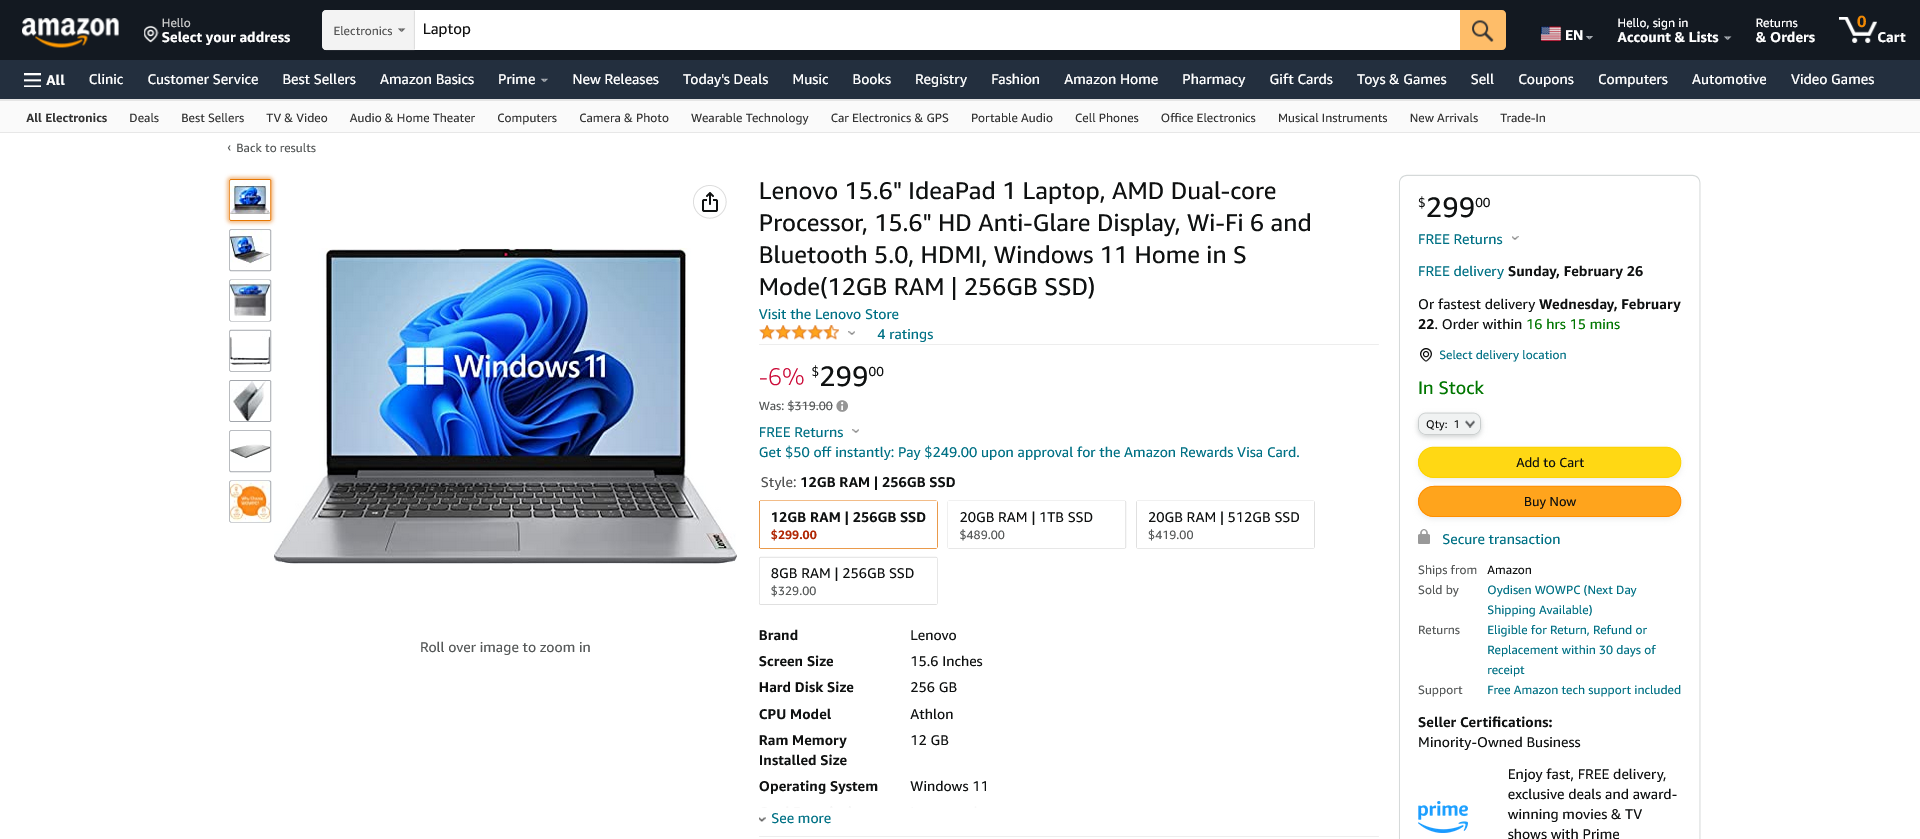

In [5]:
''' --------------- single_prodocts_handle(url, headers) -----------------------
gets: url=the url of the prodoct, headers=the thing needed to get amazon html
return: returns the list of info
the function requests the prodocts html page from amazon, 
and scraps all the info we want.
'''
def single_prodocts_handle(url, headers, prodoct_traits_dict):
    if(url == None):
        print('single_prodocts_handle got url=None')
        return None, None
    try:
        page = requests.get(url, headers=headers)
    except Exception:
        print('page requests failed')
        return None, None
    
    print(page.status_code)
    
    soup1 = BeautifulSoup(page.content, 'html.parser')
    soup2 = BeautifulSoup(soup1.prettify(), 'html.parser')
    
    prodoct_traits_dict['page.status_code'] = str(page.status_code)
    
    # scrap info
    
    # title
    title = None
    title = soup2.find(id='productTitle')
    if title is not None:
        title = title.get_text().strip()
    #prodoct_list.append(title)
    prodoct_traits_dict['Name'] = title
    
    # price
    price_text = None
    #apexPriceToPay
    price = soup2.find_all("span", {"class": "apexPriceToPay"})
    for ext in price:
        price_text = ext.find("span", {"class": "a-offscreen"}).getText().strip()
    #PriceToPay
    price = soup2.find_all("span", {"class": "priceToPay"})
    for ext in price:
        price_text = ext.find("span", {"class": "a-offscreen"}).getText().strip()
    #compiere table - incase price was not found yet
    if(price_text is None):
        table_place = soup2.find("table", {"id": "HLCXComparisonTable"})
        if(table_place is not None):
            row_place = table_place.find("tr", {"id": "comparison_price_row"})
            if(row_place is not None):
                price_place = row_place.find("td", {"class": "comparison_baseitem_column"})
                if(price_place is not None):
                    price_text = price_place.find("span", {"class": "a-color-price"})
                    if(price_text is not None):
                            price_text = price_text.getText().strip()
                            
    prodoct_traits_dict['Price'] = price_text
    
    # year
    year = None
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    for td in soup2.find_all("td", {"class": "a-size-base prodDetAttrValue"}):
        if any(ext in td.text for ext in months):
            year = td.text.strip()
            break
    prodoct_traits_dict['Release_Date'] = year
    
    # checking for diffrent tables in the page, and collect all the rows in each table
    table_place = soup2.find_all("table", {"id": 'productDetails_techSpec_section_1'})
    table_trs1 = []
    for i in table_place:
        table_trs1 = i.find_all('tr')
    
    table_place = soup2.find_all("table", {"id": 'productDetails_techSpec_section_2'})
    table_trs2 = []
    for i in table_place:
        table_trs2 = i.find_all('tr')
    
    table_place = soup2.find_all("table", {"id": 'productDetails_detailBullets_sections1'})
    table_trs3 = []
    for i in table_place:
        table_trs3 = i.find_all('tr')
    
    table_trs = table_trs1 + table_trs2 + table_trs3
    
    if table_place: #some prodocts maybe are not laptops, so they dont have tables
        for tr in table_trs:
            th_place_in_tr = tr.find("th", {"class": 'prodDetSectionEntry'})
            if(th_place_in_tr is not None):
                text_th = th_place_in_tr.getText().strip()
                if(text_th in prodoct_traits_dict):
                    td_place = tr.find("td", {"class": "prodDetAttrValue"})
                    if(td_place is not None):
                        td_text = td_place.getText().strip()
                        td_text_0 = td_text.encode("ascii", "ignore")
                        td_text = td_text_0.decode()
                    prodoct_traits_dict[text_th] = td_text
                    
    return prodoct_traits_dict, {'content':page.content,'status_code':str(page.status_code)}


In [6]:
def scrap_prodocts_from_urls_lst(lst_urls, headers, csv_name, starting_point, pickle_name, trait_dict, pkl_path):
    t_sleep = 14 + random.randint(0, 9) #how many sec to sleep between search pages
    length = len(lst_urls)
    all_ids_so_far_set = set()
    pages_dict = {}
    count_add_to_pickle = 0
    count_fail_scrap = 0
    for i in range(starting_point, length):
        url_prodoct = lst_urls[i]
        # urls without ids are trash, so no need to request them
        result_id = re.search('\w*dp/(.*)', url_prodoct) 
        # save the id so we won't reqeust the same id twies
        if((url_prodoct != None) and (result_id != None) and (result_id not in all_ids_so_far_set)):
            print('prodoct:', i)
            
            # gets info of the prodocts and returns it in a list
            #list_info, page = single_prodocts_handle(url_prodoct, headers)
            trait_dict, page = single_prodocts_handle(url_prodoct, headers, trait_dict)
            pages_dict[result_id.group(1)] = page
            if(trait_dict['page.status_code'] == 503):
                print('got blocked')
                time.sleep(5 * 60) # in secs
                trait_dict, page = single_prodocts_handle(url_prodoct, headers, trait_dict)
                pages_dict[result_id.group(1)] = page
            
            # get ID
            try:
                trait_dict['ID'] = result_id.group(1)
            except Exception:
                print('insert didnt work, ID:', result_id.group(1))
            
            # incase they block me
            print(trait_dict)
            
            count_none = 0
            for x in trait_dict:
                if trait_dict[x] is None:
                    count_none += 1
            if(count_none >= 30):
                count_fail_scrap += 1
            else:
                count_fail_scrap = 0
            
            if(count_fail_scrap >= 3):
                # i got block, wait a few mins
                print('got blocked')
                time.sleep((count_fail_scrap + 2) * 60) # in secs
                trait_dict, page = single_prodocts_handle(url_prodoct, headers, trait_dict)
                pages_dict[result_id.group(1)] = page
                print(trait_dict)
            
            
            # put prodoct in csv as new row
            # Open our existing CSV file in append mode
            with open(csv_name, 'a', encoding='UTF8') as f_object:
                field_names = trait_dict.keys()
                dictwriter_object = DictWriter(f_object, fieldnames = field_names)
                # Pass the dictionary as an argument to the Writerow()
                dictwriter_object.writerow(trait_dict)
                # Close the file object
                f_object.close()
            
            trait_dict = dict.fromkeys(trait_dict, None)
            t_sleep = 14 + random.randint(0, 9)
            time.sleep(t_sleep) # in secs
        
        all_ids_so_far_set.add(result_id)
        
        count_add_to_pickle = count_add_to_pickle + 1
        path = pkl_path/pickle_name.format(count_add_to_pickle)
        with path.open('ab') as f:
            pickle.dump(pages_dict, f)
        try:
            path = pkl_path/pickle_name.format(count_add_to_pickle - 2)
            path.unlink()
        except Exception:
            pass

Some explantion:<br>
there's the same headers again.<br>
than there are the traits of laptops that I'm looking for, besicl every trait there was in the tables that appier at the end of laptop amazon page.<br>
I use it for the first line in the csv and when I scrap.<br>

an exple for tables in a prodoct page, some laptops had more or less traits in their tables, I just checked if each trait was in the tables to combat this.

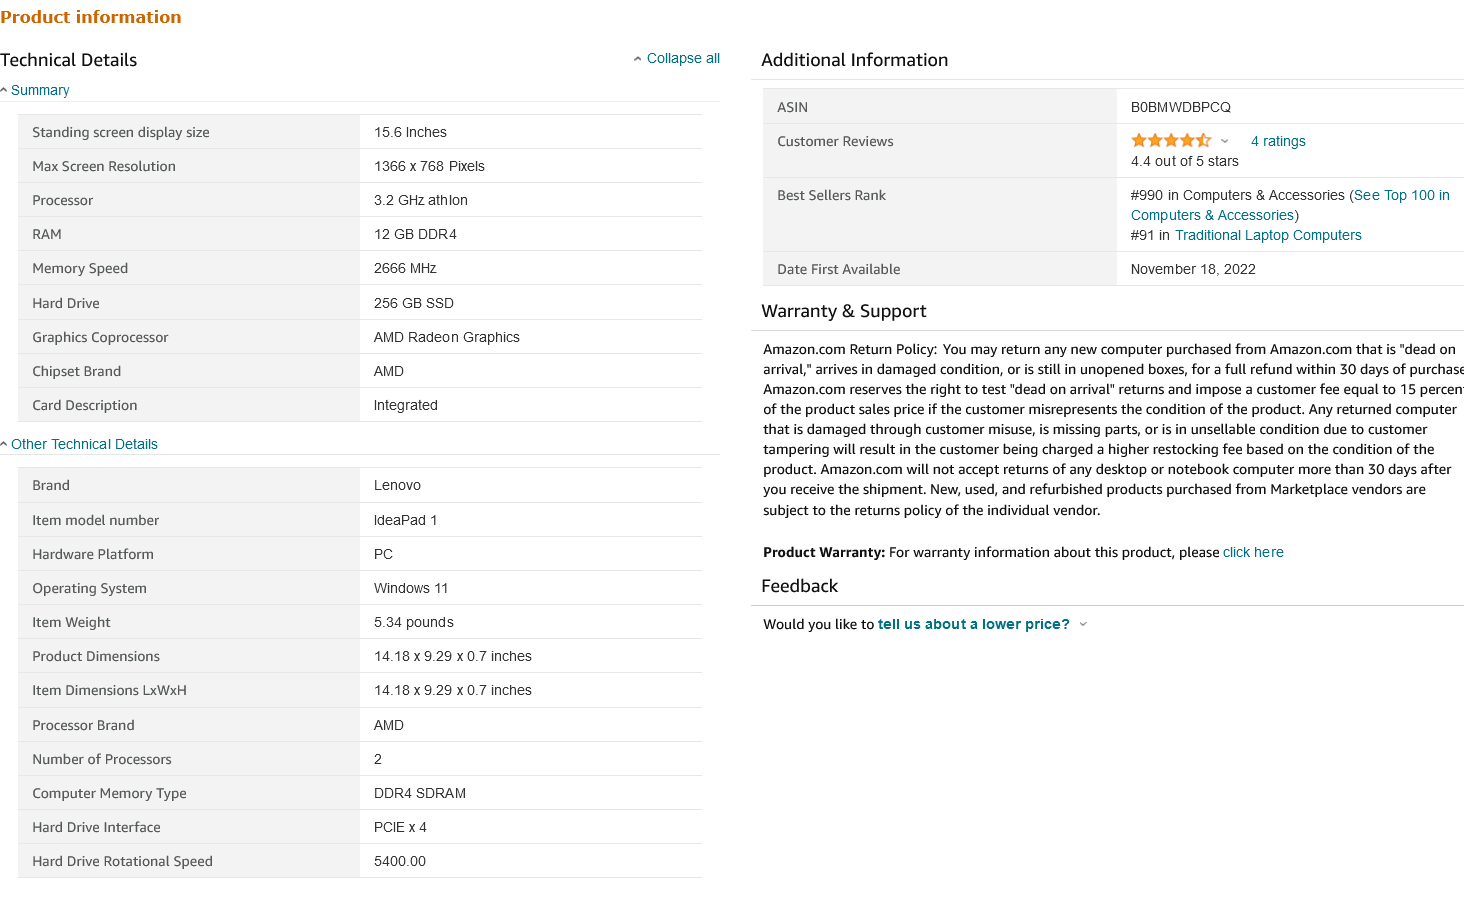

I create a new csv file for the prodocts I scrap in that seson as to not Accidentally delect csv files.<br>
the name is 'prodocts_from_{start prodoct}_{end prodoct}({which urls file I use, like the one from pages 0 to 100 of search pages})({date of scraping}).csv'<br>
I planed to merging the csv files and delete duplicet rows of prodocts<br>
<br>
So amazon blocked me, alot, so I made 'starting_point' variable and I printed the number of prodoct I was on (number of prodoct was according to the for loop in 'scrap_prodocts_from_urls_lst()'),<br>
and to print the info I scraped from the prodoct, so I could see when I was blocked and stop manually if the block took too long to lift<br>
But I also put a few tricks to avoid block or the need to manually stop it:<br>
* I put the function to sleep for a random time between every page, this did make it took alot longer to scrap but was nessery.<br>
* if the function sees that I got 3 prodocts in a row without info it would be put to sleep for 5min<br>
* and if the next prodoct was also empty it would saleep for 6min, and so on.<br>
<br>
becouse how long it took to scrap, I used a secound laptop with wifi on my phone.<br>
<br>
I also keep all the html pages in a pickel file, incase I need to scrap all over again, that way I won't need to worry about blocking the secound time.

In [7]:
# Stage 2 - get prodoct info - main
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:108.0) Gecko/20100101 Firefox/108.0", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

# the traits \ cols
basic_traits = ['page.status_code','ID','Name','Price','Release_Date']
traits_table_1 = ['Standing screen display size','Screen Resolution','Max Screen Resolution','Processor','RAM',
                     'Memory Speed','Hard Drive','Graphics Coprocessor','Chipset Brand','Card Description','Wireless Type',
                     'Number of USB 3.0 Ports','Average Battery Life (in hours)']
traits_table_2 = ['Brand','Series','Item model number','Hardware Platform',
                      'Operating System','Item Weight','Product Dimensions','Item Dimensions LxWxH','Color',
                      'Processor Brand','Number of Processors','Computer Memory Type',
                      'Flash Memory Size','Hard Drive Interface','Optical Drive Type','Power Source','Batteries']
traits_all = basic_traits + traits_table_1 + traits_table_2
traits_cols_dict = dict.fromkeys(traits_all, None)

# create CSV, for prodocts info (the main csv)
csv_name = 'prodocts_from_1223_3000(0_100)(7_feb_2023).csv'
lst_columns = traits_cols_dict.keys()
if not os.path.exists(csv_name):
    with open(csv_name, "w") as f_csv:
        # create the csv writer
        writer = csv.writer(f_csv)
        # write a row to the csv file
        writer.writerow(lst_columns)
        f_csv.close()
        pass

# get from csv/pickle a list of urls
lst_urls = []
path = 'urls_of_prodocts/'
pickle_name = path + 'urls_0_100(14_jan_2023).pkl'
with open(pickle_name, 'rb') as f_pkl:
    for i in range(1, 120):
        try:
            lst_urls.append(pickle.load(f_pkl))
        except Exception:
            pass

lst_urls_flat = [item for sublist in lst_urls for item in sublist]
print('len(lst_urls):', len(lst_urls_flat))

#create folder:
pickle_name_dict = '{0:d}.pkl'
name_folder = 'all_page_data_0_100(6_feb)'
p = pathlib.Path(name_folder)
if not os.path.exists(p):
    p.mkdir(parents=True,exist_ok=False)


# get prodocts info
# incase scraping stoped we can start from a later point in lst_urls
starting_point = 0
# un-comment to use
# scrap_prodocts_from_urls_lst(lst_urls_flat, headers, csv_name, starting_point, pickle_name_dict, traits_cols_dict, p)


len(lst_urls): 3268


<span style=background:gray>
    ----------------------------------------------------
</span>

compine all the csvs we made to one csv, so we know we didnt miss count lines and for easyier accses

In [8]:
# combine # this code is before put all the csv in foulder
os.listdir()
#path = 'prodocts_from_ALL/'
substring = 'prodocts_from' 
files = [('prodocts_from_ALL/' + file) for file in os.listdir('prodocts_from_ALL') if substring in file]
df_files = pd.concat(map(pd.read_csv, files), ignore_index=True)
# df_files.to_csv('all_prodocts_before_cleaning.csv', mode='x')
print(df_files.shape)
print(df_files.info())

(9137, 71)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9137 entries, 0 to 9136
Data columns (total 71 columns):
 #   Column                                                                                                                                                                                                   Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                   --------------  -----  
 0   page.status_code                                                                                                                                                                                         8637 non-null   float64
 1   ID                                                                                                                                                                                         

I know there is a rogue prodoct data line in the header of the csv, which makes it have more cols than it should<br>
I remove it in the start of the cleaning part

<span style=background:yellow>
    ---------------------------------------------------------------------------------------------------------------------
</span>

## <a class="anchor" id="Cleaning_data"></a> Part 2 - Cleaning data

in this section we adress how every one writes data alittle diffrently from one another, like one wrote '12.5 Inches' and another wrote '16' for Standing screen display size. 
so I will go over each col to align the data.

On the way I change cols from string/object to numeric.
I also add cols and drop cols as needed, for exp, I add a 'Resolution_Height' and 'Resolution_Width' instode of 'Max Screen Resolution' and 'Screen Resolution'. (also use tempurary cols like 'Clean_SR' which I drop after use)

mini table of contents of columns<br>
[Wireless](#Wireless) | [Date](#Date) | [disply_size](#disply_size) | [Resolution](#Resolution) | [RAM](#RAM) | 
[Memory Speed](#MemoryS) | [Hard Drive](#HardDr) | [USB 3](#USB3) | [Battery Life](#BatteryL) | [Brand](#Brand) | 
[Series](#Series) | [Hardware](#Hardware) | [Batteries](#Batteries) | [Processor](#Pro) | [Dimension](#Dim) | 
[Processor Brand](#ProB) | [Number Processor](#ProN) | [Memory Type](#MemT) | [Memory Speed](#MemS) 
| [Drive Type](#DriveT) | [Graphics Coprocessor](#GC)
 | [Chipset Brand](#CB) | [Card Description](#Des) | [Color](#color) | [Item Weight](#IW)<br>
 [Skip to the End](#Missing_data)

In [9]:
# there was a rogue prodoct data line in the header of the csv

# get df from csv (after fixing the header manually)
with open('all_prodocts_before_cleaning.fixed_header.csv', newline='', encoding="utf8") as f:
    reader = csv.reader(f)
    raw_csv_rows = list(reader)

# even if I fixed the header by rmoving the rogue prodoct manualy, the other rows in the csv have empty col
# so we are droping them

# drop cols who are after col 36
good_rows = [x[0 : 36] for x in raw_csv_rows]
#df from list of good_rows
scraping_df = pd.DataFrame.from_records(good_rows[1:], columns = good_rows[0])
# show cols that are left
scraping_df.columns

Index(['', 'page.status_code', 'ID', 'Name', 'Price', 'Release_Date',
       'Standing screen display size', 'Screen Resolution',
       'Max Screen Resolution', 'Processor', 'RAM', 'Memory Speed',
       'Hard Drive', 'Graphics Coprocessor', 'Chipset Brand',
       'Card Description', 'Wireless Type', 'Number of USB 3.0 Ports',
       'Average Battery Life (in hours)', 'Brand', 'Series',
       'Item model number', 'Hardware Platform', 'Operating System',
       'Item Weight', 'Product Dimensions', 'Item Dimensions LxWxH', 'Color',
       'Processor Brand', 'Number of Processors', 'Computer Memory Type',
       'Flash Memory Size', 'Hard Drive Interface', 'Optical Drive Type',
       'Power Source', 'Batteries'],
      dtype='object')

In [10]:
# drop first col, which was created by csv madule
df = scraping_df.drop('', axis = 1)

In [11]:
# show bad status codes
df[df['page.status_code'].astype(float) != 200]

,page.status_code,ID,Name,Price,Release_Date,Standing screen display size,Screen Resolution,Max Screen Resolution,Processor,RAM,...,Item Dimensions LxWxH,Color,Processor Brand,Number of Processors,Computer Memory Type,Flash Memory Size,Hard Drive Interface,Optical Drive Type,Power Source,Batteries
70,503.0,B09RG28T7Z,,,,,,,,,...,,,,,,,,,,
71,503.0,B09Z372YMT,,,,,,,,,...,,,,,,,,,,
8710,404.0,B0711MJ4XS,,,,,,,,,...,,,,,,,,,,


In [12]:
# drop rows with bad status (they are empty anyway)
df = df[df['page.status_code'].astype(float) == 200]
# drop status_code col it did it's job, and won't affect the price
df = df.drop('page.status_code', axis = 1)

we have some prodoct IDs which have multibple rows becuse of multipule scraping trys so we need to drop at least one of them

In [13]:
# group togeter rows with same ID
grouped_by_id = df.groupby('ID')
# make it a set
set_data_by_ID = grouped_by_id.aggregate(set)
set_data_by_ID.head()

,Name,Price,Release_Date,Standing screen display size,Screen Resolution,Max Screen Resolution,Processor,RAM,Memory Speed,Hard Drive,...,Item Dimensions LxWxH,Color,Processor Brand,Number of Processors,Computer Memory Type,Flash Memory Size,Hard Drive Interface,Optical Drive Type,Power Source,Batteries
ID,,,,,,,,,,,,,,,,,,,,,
B001P9CZ9O,"{, Dell Latitude D830 15.4"" Laptop (Intel Core...","{, $131.68}","{, October 9, 2008}","{, 15.4 Inches}",{},{},"{, 2.2 GHz Core_2_Duo}","{, 2 GB DDR2}","{, 2400 MHz}","{, 80 GB}",...,{},"{, Gray}","{, Intel}","{, 2.0}","{DDR2 SDRAM, }","{, 120 GB}","{, Ethernet}",{},"{, AC & Battery}","{, 1 Lithium Ion batteries required. (included)}"
B002AGUOCG,"{Dell Latitude D420 12"" Laptop Core Duo 1.2Ghz...",{$99.00},"{May 19, 2009}",{12.1 Inches},{1280 x 800 pixels},{1280 x 800 Pixels},{1.2 GHz intel_core_duo},{1 GB DDR2},{533 MHz},{60 GB},...,{},{Gray},{Intel},{1.0},{DDR2 SDRAM},{},{ATA100},{},{Corded Electric},{}
B002SIJFAS,{HP Elitebook 6930p FN042UT Notebook PC (2.5 G...,{},"{September 14, 2004}",{14.1 Inches},{1280 x 800 (WXGA)},{1280 x 80 (WXGA)},{2.5 GHz Core_2_Duo},{2 GB DDR2},{2.5 GHz},{250 GB HDD},...,{},{Silver},{Intel},{2.0},{DDR2 SDRAM},{},{Ethernet 100Base-T},{},{Corded Electric},{Lithium Metal batteries required.}
B002UIVK0E,{Dell E5400 Latitude 14-Inch Laptop (Dual Core...,{$139.99},"{December 19, 2005}",{14.1 Inches},{},{},{2.66 GHz intel_celeron_d},{2 GB},{2.2 GHz},{160 GB},...,{},{Grey/black},{Intel},{2.0},{SDRAM},{},{Serial ATA},{},{},{1 Lithium Ion batteries required.}
B003SDWQEY,{Dell Latitude D430 Core 2 Duo Laptop with XP},{$103.00},"{June 16, 2010}",{12.1 Inches},{},{1280 x 800},{1.2 GHz},{1 GB DDR2},{},{60 GB},...,{},{Charcoal & Black},{Intel},{2.0},{DDR2 SDRAM},{120 GB},{},{},"{Corded Electric, Battery Powered}",{}


In [14]:
# set size for each dataframe cell
set_size_by_ID = set_data_by_ID.applymap(len)
# which cols have sets with lenght grater than 2
# aka in the rows that have the same ID, the info show in which rows
(set_size_by_ID > 2).any(axis = 0)

Name                               False
Price                               True
Release_Date                       False
Standing screen display size       False
Screen Resolution                  False
Max Screen Resolution              False
Processor                          False
RAM                                False
Memory Speed                       False
Hard Drive                         False
Graphics Coprocessor                True
Chipset Brand                      False
Card Description                   False
Wireless Type                       True
Number of USB 3.0 Ports            False
Average Battery Life (in hours)    False
Brand                              False
Series                              True
Item model number                   True
Hardware Platform                  False
Operating System                   False
Item Weight                        False
Product Dimensions                 False
Item Dimensions LxWxH              False
Color           

In [15]:
# show one line from set_data_by_ID that has multi data problom
set_data_by_ID[(set_size_by_ID > 2).any(axis = 1)].iloc[15]

Name                               {, 2022 Newest ASUS Military-Grade Student Lap...
Price                                                               {, From $149.00}
Release_Date                                                   {, November 25, 2022}
Standing screen display size                                         {, 11.6 Inches}
Screen Resolution                                                                 {}
Max Screen Resolution                                          {, 1366 x 768 Pixels}
Processor                                                      {, 2.8 GHz celeron_n}
RAM                                                                    {, 4 GB DDR4}
Memory Speed                                                            {, 2666 MHz}
Hard Drive                                                            {, 256 GB SSD}
Graphics Coprocessor                                          {, Intel UHD Graphics}
Chipset Brand                                                    

In [16]:
# all the multi data problm cols
for column in set_data_by_ID.columns[(set_size_by_ID > 2).any(axis = 0)]:
    print(column)
    print(set_data_by_ID[set_size_by_ID[column] > 2][column].to_numpy())

Price
[{'', '$249.00', '$299.00'} {'', '$339.00', '$329.00'}
 {'', '$1,229.96', '$1,234.98'} {'$693.40', '$690.10', '$696.10'}
 {'', '$1,687.83', '$1,369.91'}
 {'$1,418.39', '$1,536.30', '$1,473.12', '$1,483.82', '$1,454.78'}
 {'', '$279.95', '$274.95'} {'$1,195.94', '', '$1,190.96'}]
Graphics Coprocessor
[{'', 'amd', 'Amd'}]
Wireless Type
[{'', '802.11a/b/g/n/ac, Bluetooth', 'Bluetooth, 802.11a/b/g/n/ac'}
 {'', '802.11a/b/g/n/ac, Bluetooth', 'Bluetooth, 802.11a/b/g/n/ac'}]
Series
[{'', 'na0020', 'Na0020'} {'', 'Laptop', 'laptop'} {'', 'I3511', 'i3511'}]
Item model number
[{'', '9520.0', '9520'}]
Color
[{'', 'grey', 'Grey'}]
Flash Memory Size
[{'', '256.0', '256'}]
Hard Drive Interface
[{'ESATA', 'eSATA', ''}]


many diffrences can be corrcted by changeing the data to lower cases like Gray ans gray<br>
same with '.0'

In [17]:
# change all string type col to lower case, to help group up same values like "Gray" and "gray"
df['Hard Drive Interface'] = df['Hard Drive Interface'].str.lower()
df['Color'] = df['Color'].str.lower()
df['Series'] = df['Series'].str.lower()
df['Graphics Coprocessor'] = df['Graphics Coprocessor'].str.lower()

# ".0" isn't useful so replace it with nothing to delete it
df['Flash Memory Size'] = df['Flash Memory Size'].str.replace('.0', '')
df['Item model number'] = df['Item model number'].str.replace('.0', '')

<a class="anchor" id="Wireless"></a>
<span style=background:LightBlue>
    COLUMN: 'Wireless Type'
</span> can be split to 'Bluetooth' and 'Wireless_year' which are better since they are boolen and numierc<br>
instade of string

In [18]:
# add col for if the laptop has Bluetooth
df['Bluetooth'] = df['Wireless Type'].str.lower().str.contains('bluetooth')
df['Bluetooth']

0        True
1        True
2        True
3        True
4       False
        ...  
9133    False
9134    False
9135     True
9136    False
9137     True
Name: Bluetooth, Length: 9135, dtype: bool

clean 'Price' a bit (from string to float)

In [19]:
# helps combin rows with the same ID
# keeps as much as passeble unless there's contradiction in which case puts missing
def clean_up_set(set_data):
    new_set = set(set_data)
    new_set.discard('') #remove Nan/missing
    # if the value is alone
    if len(new_set) == 1:
        #return just the value
        return list(new_set)[0]
    # if there is no value
    elif len(new_set) == 0:
        return np.NaN
    else:
        # if there is more then 1 value, return nan
        return np.NaN

In [20]:
'''
the founction handels the case where prodocts can have more then one price
this might be becouse when a scraping stoped we would go over the last few prodocts, to make sure we got them.
if the difrence in prices for a prodoct is:
    over the threshold -> remove the prodoct entirely (because...)
    under the threshold -> keep the prodoct with a new price, the mean of the prices
'''
def clean_up_prices(price_data, threshold = 30):
    new_set = set(price_data)
    new_set.discard('')
    try:
        if len(new_set) == 1:
            return set([float(list(new_set)[0].replace("$", "").replace(",", ""))])
        elif len(new_set) == 0:
            return set([np.NaN])
        else:
            prices = [float(x) for x in new_set]
            if max(prices) - min(prices) < threshold:
                return set([np.mean(prices)])
            else:
                return set([np.NaN])
    except Exception:
        return set([np.NaN])

In [21]:
# check how many IDs have price data after running clean_up_prices
sum(~set_data_by_ID['Price'].map(clean_up_prices).isna())

3596

In [22]:
'''
reorganize 'Wireless Type' col by the latest year the Wireless Type seporets,
this will make 'Wireless Type' col to numeric
'''
# See URL https://en.wikipedia.org/wiki/IEEE_802.11ac-2013
wireless_generations = [(2020, 'ax'), (2014, 'ac'), (2008, 'n'), (2003, 'g'), (1999, 'a'), (1999, 'b')]

def wireless_latest_year(wireless_string):
    for (year, letters) in wireless_generations:
        if re.search(r'802\.11' + letters, wireless_string):
            return year
    return np.NaN

def wireless_year_from_set(wireless_set):
    years = [wireless_latest_year(x) for x in wireless_set]
    years = [x for x in years if not np.isnan(x)]
    if len(years) == 0:
        return set([np.NaN])
    return set([max(years)])

In [23]:
# do the grouping again, to see if we fixed some cols
grouped_by_id = df.groupby('ID')
set_data_by_ID = grouped_by_id.aggregate(set)
set_size_by_ID = set_data_by_ID.applymap(len)
(set_size_by_ID > 2).any(axis = 0)

Name                               False
Price                               True
Release_Date                       False
Standing screen display size       False
Screen Resolution                  False
Max Screen Resolution              False
Processor                          False
RAM                                False
Memory Speed                       False
Hard Drive                         False
Graphics Coprocessor               False
Chipset Brand                      False
Card Description                   False
Wireless Type                       True
Number of USB 3.0 Ports            False
Average Battery Life (in hours)    False
Brand                              False
Series                             False
Item model number                  False
Hardware Platform                  False
Operating System                   False
Item Weight                        False
Product Dimensions                 False
Item Dimensions LxWxH              False
Color           

In [24]:
# do clean up with the functions
set_data_by_ID['Price'] = set_data_by_ID['Price'].map(clean_up_prices)
set_data_by_ID['Wireless_Year'] = set_data_by_ID['Wireless Type'].map(wireless_year_from_set)
print(set_data_by_ID['Wireless_Year'].value_counts())

{nan}     1891
{1999}     564
{2014}     547
{2020}     537
{2003}      34
{2008}      23
Name: Wireless_Year, dtype: int64


In [25]:
# now check if we fixed it
set_size_by_ID = set_data_by_ID.applymap(len)
(set_size_by_ID > 2).any(axis = 0)

Name                               False
Price                              False
Release_Date                       False
Standing screen display size       False
Screen Resolution                  False
Max Screen Resolution              False
Processor                          False
RAM                                False
Memory Speed                       False
Hard Drive                         False
Graphics Coprocessor               False
Chipset Brand                      False
Card Description                   False
Wireless Type                       True
Number of USB 3.0 Ports            False
Average Battery Life (in hours)    False
Brand                              False
Series                             False
Item model number                  False
Hardware Platform                  False
Operating System                   False
Item Weight                        False
Product Dimensions                 False
Item Dimensions LxWxH              False
Color           

In [26]:
# create new df from set_data_by_ID
df2 = set_data_by_ID.applymap(clean_up_set)
# drop 'Wireless Type', now that we have Wireless_Year, we dont need it
df2 = df2.drop('Wireless Type', axis = 1)

In [27]:
#save my work
# df2.to_csv('initially_cleaned_data.csv',mode='x')

<a class="anchor" id="Date"></a>
<span style=background:LightBlue>
    COLUMN: Date
</span>

In [28]:
# convert date to secands
def date_number(date_string):
    if not isinstance(date_string, str):
        return np.NaN
    date_string = re.sub(r"[^a-zA-Z0-9 ]", "", date_string)
    formats = ["%B %d, %Y", "%B %d %Y"]
    the_datetime = datetime.datetime(1,1,1)
    for the_format in formats:
        try:
            the_datetime = the_datetime.strptime(date_string, the_format)
            return (the_datetime - datetime.datetime(1970, 1, 1)).total_seconds()
        except Exception:
            pass
    return np.NaN

In [29]:
# change col 'Release_Date' values from string to secaonds
df2['Numeric_Release_Date'] = df2['Release_Date'].map(date_number)
df2[df2['Numeric_Release_Date'].isna()]['Release_Date'].unique()

array([nan], dtype=object)

<a class="anchor" id="display size"></a>
<span style=background:LightBlue>
    COLUMN: 'Standing screen display size'
</span>

In [30]:
# all the unique values in 'Standing screen display size' col
df2['Standing screen display size'].unique()

array(['15.4 Inches', '12.1 Inches', '14.1 Inches', '15.6 Inches',
       '17 Inches', '10.1 Inches', '14 Inches', '17.3 Inches',
       '10.2 Inches', '13.3 Inches', nan, '13.9 Inches', '15 Inches',
       '11.6 Inches', '12.5 Inches', '10 Inches', '11 Inches',
       '12 Inches', '13 Inches', '12.3 Inches', '0.1', '17.3', '3',
       '13.4 Inches', '11.6', '23.8 Inches', '15.5 Inches', '16.1 Inches',
       '15.6', '16 Inches', '13.5 Inches', '16', '13', '14', '13.3', '15',
       '16.2 Inches', '1', '27 Inches', '13.7 Inches', '13.6 Inches',
       '14.5 Inches', '12.66 Inches', '13.99 Inches'], dtype=object)

In [31]:
# reorganize values in 'Standing screen display size' col
# exp: '13.5 Inches' to 13.5 (numeric)
def display_size_as_number(the_string, size_threshold = 4):
    if not isinstance(the_string, str):
        return np.NaN
    the_string = re.sub(r"[^a-zA-Z0-9. ]", "", the_string).lower()
    the_string = the_string.replace("inches", "")
    try:
        the_size = float(the_string)
        return the_size if the_size > size_threshold else np.NaN
    except Exception:
        return np.NaN

In [32]:
df2['Numeric_display_size'] = df2['Standing screen display size'].map(display_size_as_number)
df2['Numeric_display_size'].unique()

array([15.4 , 12.1 , 14.1 , 15.6 , 17.  , 10.1 , 14.  , 17.3 , 10.2 ,
       13.3 ,   nan, 13.9 , 15.  , 11.6 , 12.5 , 10.  , 11.  , 12.  ,
       13.  , 12.3 , 13.4 , 23.8 , 15.5 , 16.1 , 16.  , 13.5 , 16.2 ,
       27.  , 13.7 , 13.6 , 14.5 , 12.66, 13.99])

<a class="anchor" id="Resolution"></a>
<span style=background:LightBlue>
    COLUMN: 'Max Screen Resolution' and 'Screen Resolution'
</span>:<br>
those two cols are almost the same thing, so I am combinng them to one col by choseing the biger one of the two<br>
but first I change them from string to pairs of numbers, than I chose the biger one<br>
after this I split the col to two cols for width and height

In [33]:
# see the mess
df2['Max Screen Resolution'].unique()

array([nan, '1280 x 800 Pixels', '1280 x 80 (WXGA)', '1280 x 800',
       '1440 x 900 Pixels', '1024 x 600 Pixels', '1366 x 768',
       '1600 x 900', '1366x768', '1200 x 800', '1920x1080',
       '1366 x 768 Pixels', '1920x1080 Pixels', '1600 x 900 Pixels',
       '1920 x 1080 Pixels', '1920 x 1080', '1366x768 Pixels',
       '1920*1080 Pixels', '1366*768 Pixels', '1600x900',
       '1920x1080 pixels', '1366 x 768 pixels', '2560 x 1600 Pixels',
       '1366 x 768 (HD Touch)', '3200X1800 pixels',
       'default_no_selection_value', '1920X1080 Pixels',
       '1366X768 Pixels', '1920 x 1080 FHD', '3200 x 1800 Pixels',
       '1440x900 Pixels', '2880x1800', '2560-by-1600', '2560x1600 Pixels',
       '2304x1440', '2560 x 1440', 'HD 1366x768', '1440x900',
       '2560x1600 pixels', '3840 x 2160 Pixels', '3000 x 2000',
       'HD anti-glare LED Backlight Screen', '2880x1800 pixels',
       'Anti-Glare Display Non-Touchscreen', '3840 x 2160',
       '1920 x 1080 pixels', '1366 x 768 HD Reso

In [34]:
# reorganize values in 'Max Screen Resolution' col
# into 2 new cols: ''
# exp: 1920 x 1080 Pixels -> 1920:Resolution_Width and 1080:Resolution_Height

# from string to pair of numbers
def clean_resolution(the_string):
    # return pair of width and height
    if not isinstance(the_string, str):
        return np.NaN
    the_string = re.sub(r"[^a-zA-Z0-9 ]", "", the_string).lower()
    formats = [r"(\d+)\s*[x*]\s*(\d+)"]
    for the_format in formats:
        the_match = re.search(the_format, the_string)
        if the_match:
            return the_match.groups()
    return (np.NaN, np.NaN)

def combined_resolution(the_resolutions):
    (screen_resolution, max_screen_resolution) = [the_resolutions[x] 
                                                  for x in ['Clean_SR', 'Clean_MSR']]
    # combine the two resolution columns
    if not isinstance(screen_resolution, tuple):
        return max_screen_resolution
    if not isinstance(max_screen_resolution, tuple):
        return screen_resolution
    if isinstance(screen_resolution[0], str):
        screen_resolution = [int(x) for x in screen_resolution]
    if isinstance(max_screen_resolution[0], str):
        max_screen_resolution = [int(x) for x in max_screen_resolution]
    if np.isnan(screen_resolution[0]):
        return max_screen_resolution
    if np.isnan(max_screen_resolution[0]):
        return screen_resolution
    try:
        return tuple([max(x, y) for (x, y) in zip(screen_resolution,
                                                  max_screen_resolution)])
    except Exception:
        print("DBG", the_resolutions)
        print("DBG", repr(the_resolutions))
        print("DBG", (screen_resolution, max_screen_resolution))
        raise

def width_from_resolution(resolution):
    return resolution[0] if isinstance(resolution, tuple) else np.NaN

def height_from_resolution(resolution):
    return resolution[1] if isinstance(resolution, tuple) else np.NaN

In [35]:
# from string to pairs of numbers
df2['Clean_SR'] = df2['Screen Resolution'].map(clean_resolution)
df2['Clean_MSR'] = df2['Max Screen Resolution'].map(clean_resolution)
# now combin
df2['Combined_Resolution'] = df2[['Clean_SR', 'Clean_MSR']].apply(combined_resolution, axis = 1, 
                                                                                  result_type = 'reduce')

In [36]:
# spilt the col to two cols
df2['Resolution_Width'] = df2['Combined_Resolution'].map(width_from_resolution)
df2['Resolution_Height'] = df2['Combined_Resolution'].map(height_from_resolution)

In [37]:
repr(df2['Resolution_Width'].values)

"array([nan, 1280, 1280, ..., 1920, 1920, '1920'], dtype=object)"

for some reason there are 1920 and 1920 and '1920', so I need to go again to make them all to int

In [38]:
df2['Resolution_Height'] = df2['Resolution_Height'].map(lambda x : int(x) if isinstance(x,str) else x)
df2['Resolution_Width'] = df2['Resolution_Width'].map(lambda x : int(x) if isinstance(x,str) else x)

In [39]:
print(df2['Resolution_Width'].unique())

[   nan  1280.  1440.  1024.  1366.  1600.  1200.  1920.  2560.  3200.
  2880.  2304.  3840.  3000.  1900.  1368.  1360.   366.  2048.  3456.
  2160.  2240.  2256.  2000.  3072.  1921. 19200.  1367.  4096.  2736.
  1370.]


I'm droping the cols that are not needed any more, I made new ones out of them

In [40]:
df3 = df2.drop(['Release_Date', 'Standing screen display size',
                                'Screen Resolution', 'Max Screen Resolution',
                                'Clean_SR', 'Clean_MSR', 'Combined_Resolution'], axis = 1)

In [41]:
# df3.to_csv('cleaned_data_stage_2.csv', mode='x')

<a class="anchor" id="RAM"></a>
<span style=background:LightBlue>
    COLUMN: RAM
</span>

In [42]:
# reorganize 'RAM' col to numeic
def numeric_ram(the_string):
    if not isinstance(the_string, str):
        return np.NaN
    the_string = re.sub(r"[^a-zA-Z0-9 ]", "", the_string).lower()
    formats = [r"(\d+)\s*gb"]
    for the_format in formats:
        the_match = re.search(the_format, the_string)
        if the_match:
            return int(the_match.group(1))
    return np.NaN

In [43]:
df3['Numeric_RAM'] = df3['RAM'].map(numeric_ram)

<a class="anchor" id="MemoryS"></a>
<span style=background:LightBlue>
    COLUMN: 'Memory Speed'
</span>

In [44]:
# reorganize 'Memory Speed' col to numeic
def numeric_memory_speed(the_string):
    if not isinstance(the_string, str):
        return np.NaN
    the_string = re.sub(r"[^a-zA-Z0-9. ]", "", the_string).lower()
    formats_and_conversions = [(r"([0-9.]+)\s*mhz", lambda x: float(x)),
                               (r"([0-9.]+)\s*ghz", lambda x: 1.e3 * float(x)),
                               (r"([0-9.]+)", lambda x: 1.e3 * float(x) if float(x) < 100 else float(x))]
    for (the_format, conversion_fn) in formats_and_conversions:
        the_match = re.search(the_format, the_string)
        if the_match:
            return conversion_fn(the_match.group(1))
    return np.NaN

In [45]:
df3['Numeric_Memory Speed'] = df3['Memory Speed'].map(numeric_memory_speed)

<a class="anchor" id="HardDr"></a>
<span style=background:LightBlue>
    COLUMN: 'Hard Drive'
</span> to Numeric_Drive_Capacity and Drive_Type

In [46]:
def hard_drive_category(the_string):
    if not isinstance(the_string, str):
        return np.NaN
    the_string = re.sub(r"[^a-zA-Z0-9. ]", "", the_string).lower()
    formats_and_conversions = [(r"(hdd|hard drive)", lambda x: 'HDD'),
                               (r"(ssd|emmc|solid state drive)", lambda x: 'SSD'),
                               (r"(hhd|hybrid)", lambda x: 'Hybrid')]
    for (the_format, conversion_fn) in formats_and_conversions:
        the_match = re.search(the_format, the_string)
        if the_match:
            return conversion_fn(the_match.group(1))
    return np.NaN

def numeric_drive_capacity(the_string):
    if not isinstance(the_string, str):
        return np.NaN
    the_string = re.sub(r"[^a-zA-Z0-9. ]", "", the_string).lower()
    formats_and_conversions = [(r"([0-9.]+)\s*kb", lambda x: float(x)),
                               (r"([0-9.]+)\s*mb", lambda x: 1.e3 * float(x)),
                               (r"([0-9.]+)\s*gb", lambda x: 1.e6 * float(x)),
                               (r"([0-9.]+)\s*tb", lambda x: 1.e9 * float(x))]
    for (the_format, conversion_fn) in formats_and_conversions:
        the_match = re.search(the_format, the_string)
        if the_match:
            return conversion_fn(the_match.group(1))
    return np.NaN

In [47]:
df3['Numeric_Drive_Capacity'] = df3['Hard Drive'].map(numeric_drive_capacity)
df3['Drive_Type'] = df3['Hard Drive'].map(hard_drive_category)

<a class="anchor" id="USB3"></a>
<span style=background:LightBlue>
    COLUMN: 'Number of USB 3.0 Ports'
</span>

In [48]:
# from string to float
df3['Number of USB 3.0 Ports'] = df3['Number of USB 3.0 Ports'].map(lambda x: float(x) if isinstance(x, str) else x)


lets do price clean up, I don't need any row without a price

In [49]:
print(len(df3))
# drop rows with NaN in the Price col
df4 = df3[~df3['Price'].isnull()]
print(len(df4))

3596
2670


<a class="anchor" id="BatteryL"></a>
<span style=background:LightBlue>
    COLUMN: 'Average Battery Life (in hours)'
</span><br>
to Numeric_Battery_Capacity and Numeric_Battery_Life

In [50]:
df4['Average Battery Life (in hours)'].unique()

array([nan, '6 Hours', '30 minutes', '3 Hours', '9 Hours', '12 Hours',
       '5.5 Hours', '19 Hours', '9.5 Hours', '8 Hours', '7 Hours',
       '10.5 Hours', '5.25 Hours', '5 Hours', '8.6 Hours', '1 Hours',
       '11 Hours', '10 Hours', '0.75 Hours', '14 Hours', '1.5 Hours',
       '42 Watt Hours', '10.25 Hours', '4 Hours', '1 days', '17 Hours',
       '2 Hours', '8.0, 10.0 Hours', '3 \tyears', '24 Hours', '20 Hours',
       '9.0, 13.0, 16.0 Hours', '15 Hours', '13 Hours', '76 Watt Hours',
       '8.25 Hours', '30 Hours', '8.5 Hours', '50 Watt Hours',
       '16.5 Hours', '9.0, 11.0, 6.0 Hours', '7.0, 10.0, 12.0 Hours',
       '48 Watt Hours', '35 Watt Hours', '7.0, 10.0 Hours',
       '45 Watt Hours', '7.0, 8.0 Hours', '9.25 Hours', '13.5 Hours',
       '10.15 Hours', '2 \tyears', '14.25 Hours', '7.5 Hours',
       '3.5 Hours', '8.0, 10.0, 6.0 Hours', '13.04 Hours',
       '9.0, 10.0 Hours', '15.45 Hours', '16 Hours', '23 Hours',
       '9.0, 5.0 Hours', '10.0, 18.0 Hours', '18 Hour

In [51]:
# general functions for converting string data of columns to numbers
def convert_column(the_string, formats_and_conversions):
    if not isinstance(the_string, str):
        return np.NaN
    the_string = re.sub(r"[^a-zA-Z0-9. ]", "", the_string).lower()
    for (the_format, conversion_fn) in formats_and_conversions:
        the_match = re.search(the_format, the_string)
        if the_match:
            return conversion_fn(the_match.group(1))
    return np.NaN

def average_all_numbers(the_string):
    the_matches = re.findall(r"(\d+(\.\d*)?|\.\d+)", the_string)
    if len(the_matches) == 0:
        return np.NaN
    return np.mean([float(x[0]) for x in the_matches])

In [52]:
# "watt hour" is unit of capacity, "hour" is unit of battery life time, so separate into two columns
def numeric_battery_life(the_string):
    formats_and_conversions = [(r"([0-9. ]+)\s*hour", lambda x: average_all_numbers(x)),
                               (r"([0-9. ]+)\s*minute", lambda x: average_all_numbers(x) / 60)]
    return convert_column(the_string, formats_and_conversions)

def numeric_battery_capacity(the_string):
    formats_and_conversions = [(r"([0-9.]+)\s*watt hour", lambda x: average_all_numbers(x))]
    return convert_column(the_string, formats_and_conversions)

In [53]:
# don't know why but this is needed to work
try:
    df4 = df4.drop(['Numeric_Battery_Capacity', 'Numeric_Battery_Life'], axis = 1)
except Exception:
    pass

#
df4['Numeric_Battery_Capacity'] = df4['Average Battery Life (in hours)'].map(numeric_battery_capacity)
df4['Numeric_Battery_Life'] = df4['Average Battery Life (in hours)'].map(numeric_battery_life)

In [54]:
# df4.to_csv('cleaned_data_stage_3.csv', mode='x')

<a class="anchor" id="Brand"></a>
<span style=background:LightBlue>
    COLUMN: Brand
</span>

In [55]:
df4['Brand'].unique()

array(['Dell', 'Lenovo', 'HP', nan, 'ASUS', 'Apple', 'SAMSUNG', 'IdeaPad'],
      dtype=object)

In [56]:
df4['Clean_Brand'] = df4['Brand'].str.lower().replace("ideapad", "lenovo")
df4['Clean_Brand'].unique()

array(['dell', 'lenovo', 'hp', nan, 'asus', 'apple', 'samsung'],
      dtype=object)

<a class="anchor" id="Series"></a>
<span style=background:LightBlue>
    COLUMN: Series
</span>

In [57]:
df4['Series'].unique()

array(['latitude', 'dell latitude e5400', 'dell latitude', ...,
       'tuf gaming a17', '2023 newest lenovo 15.6" ideapad',
       'latitude 5420 laptop'], dtype=object)

In [58]:
# function to assign category from a list to a string value
# alphabet_re is a regular expression for all characters to be removed
# preprocessing_fn is a function to process the string before searching for categories
# using_order : if False, only return a category if it is the only one found;
#      if True, return first category found from list
def series_category(the_string, the_categories, alphabet_re = None, preprocessing_fn = None, using_order = False):
    if not isinstance(the_string, str):
        return np.NaN
    if alphabet_re is not None:
        the_string = re.sub(alphabet_re, " ", the_string)
    if preprocessing_fn is not None:
        the_string = preprocessing_fn(the_string)
    categories = [x 
                  for x in the_categories
                  if the_string.lower().find(x) >= 0]
    if len(categories) == 0:
        return np.NaN
    if not using_order and len(categories) != 1:
        return np.NaN
    return categories[0]

In [59]:
# count words occuring in series so we can decide on more useful categories
series_words = {}
for the_series_string in df4['Series']:
    if not isinstance(the_series_string, str):
        continue
    for the_word in the_series_string.lower().split():
        if len(the_word) > 0:
            series_words[the_word] = series_words.get(the_word, 0) + 1
for brand in df4['Clean_Brand'].unique():
    if brand in series_words:
        del series_words[brand]
        
frequency_cutoff = 30
bad_keys = []
for (key, value) in series_words.items():
    if value > frequency_cutoff:
        print((key, value))
    else:
        bad_keys.append(key)
# manually clean garbage
for key in list(series_words.keys()): # use list() to prevent "changed during iteration" error
    try:
        int(key)
        # delete key if it is a string of integer
        del series_words[key]
        continue
    except Exception:
        pass
    # chromebooks are identified using "Operating System"
    if ((key in ('laptop', 'gaming', 'notebook', 'newest', 'flex', 'chromebook'))
        or (key in bad_keys)):
        del series_words[key]

print(list(series_words.keys()))

# check how many series strings have more than one significant word
for the_series_string in df4['Series']:
    if not isinstance(the_series_string, str):
        continue
    total = 0
    for the_word in the_series_string.lower().split():
        if len(the_word) > 0:
            if the_word in series_words:
                total += 1
    if total > 1:
        print(the_series_string)
        
series_categories = list(series_words.keys())

df4['Clean_Series'] = df4['Series'].map(lambda x: series_category(x, series_categories))

('latitude', 235)
('pavilion', 101)
('x360', 34)
('elitebook', 35)
('xps', 64)
('15', 90)
('thinkpad', 148)
('laptop', 183)
('inspiron', 116)
('rog', 35)
('chromebook', 142)
('pro', 44)
('precision', 47)
('stream', 31)
('flex', 41)
('5', 54)
('ideapad', 198)
('zenbook', 50)
('envy', 54)
('vivobook', 102)
('legion', 33)
('14', 58)
('gaming', 33)
('3', 58)
('gen', 52)
['latitude', 'pavilion', 'x360', 'elitebook', 'xps', 'thinkpad', 'inspiron', 'rog', 'pro', 'precision', 'stream', 'ideapad', 'zenbook', 'envy', 'vivobook', 'legion', 'gen']
hp pavilion x360 convertible
asus zenbook pro 15
hp - envy x360 3vu70ua
hp pavilion x360
hp elitebook x360 1030 g2
zenbook pro duo
hp pavilion x360
hp pavilion x360 14 laptop
envy x360 convertible
thinkpad e15 gen 2
thinkpad t15 gen 1
hp pavilion x360
hp envy x360 2-in-1
envy x360
thinkpad x1 extreme gen 3
thinkpad p16 gen 1
envy x360
elitebook x360 830 g7
thinkpad p15 gen 1 with nvidia quadro rtx 4000 max-q design
thinkpad p15 gen 1
zenbook pro duo 15
t

<a class="anchor" id="Hardware"></a>
<span style=background:LightBlue>
    COLUMN: 'Hardware Platform' and 'Operating System'
</span>

In [60]:
df4['Hardware Platform'].unique()

array(['PC', 'Windows', nan, 'Mac', 'Linux', 'Unknown', 'Chrome',
       'Chrome OS', '356020306,356044818,381083666,18264490012', '15',
       '2-in-1 Business and Home Laptop/tablet', 'Traditional Laptop',
       'Gaming and Entertainment Laptop Computer', 'Google', 'Chromebook',
       '_', 'Android', 'Laptop', 'PCD', 'MacOS', 'Mac, macOS'],
      dtype=object)

In [61]:
df4['Operating System'].unique()

array(['Windows XP;', 'MS Windows XP Professional', 'Windows xp',
       'Windows 7', nan, 'Windows 7 Home Premium 32-bit', 'Windows 10',
       'Windows 8', 'Windows Vista Home Premium',
       'Windows 7 Professional', 'Windows 11 Home',
       'Windows 7 Home Premium', 'Windows 8 Professional',
       'Windows 11 Pro', 'Windows 10 Pro', 'Chrome OS', 'Windows 8.1',
       'Windows 10;', 'Mac OS', 'Windows 8 Pro', 'macOS 10 12 Sierra',
       'Windows 10 Pro 64', 'Windows 10 DG Windows 7 Pro 64',
       'Windows 10 Home', 'OS X 10.8 Mountain Lion',
       'Win 10 Pro 64 Bit Multi-Language Support English/French/Spanish(Renewed)',
       'Windows 10 Pro 64 Bit', 'macOS 10.12 Sierra',
       'MacOS 10.14 Mojave', 'inter core i5+', 'macOS 10.14 Mojave',
       'Windows 10 Professional 64 Bit, Multi-Language Support English/Spanish',
       'MacOS 10.13 High Sierra', 'macOS 10.13 High Sierra',
       'Windows 10 Professional 64-bit', 'Windows 11',
       'OS X 10.10 Yosemite', 'Windows 10

In [62]:
clean_os_categories = ["windows xp", "windows 7", "windows 8", "windows 10", "windows 11", 
                       "linux", "macos", "os x", "chrome"] 
df4['Clean_Operating_System'] = df4['Operating System'].map(lambda x: series_category(x, 
                                                                                                      clean_os_categories))
df4['Clean_Operating_System'] = df4['Clean_Operating_System'].replace("os x", "macos")
df4['Clean_Operating_System'] = df4['Clean_Operating_System'].replace("chrome", "chrome os")

# Chrome OS can appear in other columns
print(df4['Clean_Operating_System'].value_counts())
df4['Chrome_OS_override'] = ((df4['Name'].str.lower().str.contains("chromebook"))
                                     | (df4['Hardware Platform'].str.lower().str.contains("chrome"))
                                     | (df4['Series'].str.lower().str.contains("chromebook")))
df4['Clean_Operating_System'] = df4[['Clean_Operating_System']].where(~df4['Chrome_OS_override'], 
                                                                                      "chrome os")
print(df4['Clean_Operating_System'].value_counts())


windows 10    1363
windows 11     827
chrome os      225
windows 7       29
windows 8       11
macos           11
windows xp       7
linux            1
Name: Clean_Operating_System, dtype: int64
windows 10    1355
windows 11     827
chrome os      246
windows 7       29
windows 8       11
macos           11
windows xp       7
linux            1
Name: Clean_Operating_System, dtype: int64


<a class="anchor" id="Batteris"></a>
<span style=background:LightBlue>
    COLUMN: Batteries
</span>

In [63]:
print(df4['Batteries'].unique())

['1 Lithium Ion batteries required. (included)' nan
 '1 Lithium Ion batteries required.'
 '1 Product Specific batteries required.'
 '1 Lithium Polymer batteries required. (included)'
 '1 Lithium Metal batteries required.'
 '1 Lithium Polymer batteries required.'
 '2 Lithium Ion batteries required. (included)'
 '2 Lithium Polymer batteries required. (included)'
 '2 Lithium Ion batteries required.' '1 A batteries required.'
 '1 A batteries required. (included)'
 '100 Lithium Ion batteries required. (included)'
 '1 Lithium Metal batteries required. (included)'
 '1 C batteries required. (included)' '1 12V batteries required.'
 '1 C batteries required.' '3 Lithium Ion batteries required. (included)'
 '1 Unknown batteries required.' '1 LR44 batteries required. (included)'
 '1 12V batteries required. (included)'
 '4 Lithium Ion batteries required. (included)'
 '3 AAA batteries required.' '1 9V batteries required.'
 '1 9V batteries required. (included)'
 '1 AAA batteries required. (included)'


In [64]:
lithium_technologies = ["lithium ion", "lithium polymer", "lithium metal"]
df4['Lithium_Battery_Technology'] = df4['Batteries'].map(lambda x: 
                                                                         series_category(x, lithium_technologies))
df4['Lithium_Battery_Technology'].value_counts()

lithium ion        1278
lithium polymer     210
lithium metal        63
Name: Lithium_Battery_Technology, dtype: int64

droping cols that I don't need any more

In [65]:
# after reorganizing some cols, spicicly by msking new cols. we can drop the old cols
df5 = df4.drop(['Batteries', 'Operating System', 'Hardware Platform', 'Series',
                                'Brand', 'Average Battery Life (in hours)', 'Memory Speed',
                                'Hard Drive', 'RAM', 'Chrome_OS_override'], axis = 1)
# renameing cols
df5 = df5.rename(columns = {'Numeric_display_size' : 'Numeric_Display_Size',
                                            'Numeric_Memory Speed' : 'Numeric_Memory_Speed'})

In [66]:
# df5.to_csv('cleaned_data_stage_4.csv', mode='x')

In [67]:
df5.columns

Index(['Name', 'Price', 'Processor', 'Graphics Coprocessor', 'Chipset Brand',
       'Card Description', 'Number of USB 3.0 Ports', 'Item model number',
       'Item Weight', 'Product Dimensions', 'Item Dimensions LxWxH', 'Color',
       'Processor Brand', 'Number of Processors', 'Computer Memory Type',
       'Flash Memory Size', 'Hard Drive Interface', 'Optical Drive Type',
       'Power Source', 'Bluetooth', 'Wireless_Year', 'Numeric_Release_Date',
       'Numeric_Display_Size', 'Resolution_Width', 'Resolution_Height',
       'Numeric_RAM', 'Numeric_Memory_Speed', 'Numeric_Drive_Capacity',
       'Drive_Type', 'Numeric_Battery_Capacity', 'Numeric_Battery_Life',
       'Clean_Brand', 'Clean_Series', 'Clean_Operating_System',
       'Lithium_Battery_Technology'],
      dtype='object')

<a class="anchor" id="Pro"></a>
<span style=background:LightBlue>
    COLUMN: Processor
</span>

In [68]:
df5['Processor'].unique()

array(['2.2 GHz Core_2_Duo', '1.2 GHz intel_core_duo',
       '2.66 GHz intel_celeron_d', '1.2 GHz', '2.4 GHz core_i5', nan,
       '2.5 GHz core_i5', '2 GHz intel_core_2_duo', '1.6 GHz atom_n2600',
       'core_i7', '2.4 GHz Core_2_Duo', '4 GHz core_i7',
       '1.7 GHz core_i5', '2.3 GHz core_i5', '4.2 GHz core_i5',
       '2.4 GHz core_i3', '2.1 GHz core_i7', '1.8 GHz core_i5',
       '1.6 GHz apple_ci5', '2.7 GHz core_i7', 'core_i5',
       '2.6 GHz Core_i5_4200H', '1.7 GHz Exynos_5250', '2.67 GHz core_i5',
       '1.83 GHz intel_core_duo', '1.83 GHz core_duo', '2.16 GHz celeron',
       '1.9 GHz core_i3', '2 GHz core_i7', '1.66 GHz intel_core_2_duo',
       '1.33 GHz intel_atom', '2.5 GHz core_i7', 'celeron',
       '1.9 GHz core_i5', '2.6 GHz core_i7', '2.6 GHz core_i5',
       '3 GHz core_i7', '2.1 GHz celeron', 'intel_atom', 'apple_ci5',
       '2.9 GHz core_i7', '1.83 GHz celeron', '1.3 GHz core_i5',
       '3.2 GHz core_i7', '2.5 GHz core_i5_family', '1.4 GHz core_i5',
      

there are so many things in this, so 2 cols, one for speed and one for type<br>

In [69]:
# count words occuring in series so we can decide on more useful categories
def word_counts(series, alphabet_re = r'[^a-zA-Z0-9. ]'):
    the_counts = {}
    for the_series_string in series:
        if not isinstance(the_series_string, str):
            continue
        the_series_string = re.sub(alphabet_re, " ", the_series_string)
        for the_word in the_series_string.lower().split():
            if len(the_word) > 0:
                the_counts[the_word] = the_counts.get(the_word, 0) + 1
    return the_counts

In [70]:
processor_word_counts = word_counts(df5['Processor'])
print(processor_word_counts)

{'2.2': 21, 'ghz': 2323, 'core': 1177, '2': 85, 'duo': 13, '1.2': 34, 'intel': 118, '2.66': 1, 'celeron': 292, 'd': 7, '2.4': 188, 'i5': 482, '2.5': 48, '1.6': 85, 'atom': 6, 'n2600': 1, 'i7': 446, '4': 64, '1.7': 56, '2.3': 133, '4.2': 94, 'i3': 179, '2.1': 91, '1.8': 71, 'apple': 207, 'ci5': 82, '2.7': 47, '2.6': 187, '4200h': 1, 'exynos': 1, '5250': 1, '2.67': 1, '1.83': 5, '2.16': 6, '1.9': 23, '1.66': 1, '1.33': 1, '3': 157, '2.9': 23, '1.3': 29, '3.2': 31, 'family': 199, '1.4': 4, '3.3': 44, 'n3050': 1, '3.1': 14, '6500u': 1, '3.5': 37, '7200u': 2, 'pentium': 76, 'n3540': 1, '2.8': 125, 'amd': 196, 'a': 26, 'series': 85, '1': 61, 'athlon': 45, '64': 3, '4200': 1, 'plus': 3, '1.1': 218, 'n': 46, '6600u': 5, '3.9': 13, 'quad': 2, 'n3060': 2, '3.6': 29, '4250u': 1, '3520m': 1, '740qm': 1, '15.6': 1, '3320m': 1, 'xeon': 5, '8550u': 3, 'ci7': 78, '2.48': 2, '8032': 23, 'm': 16, '6y54': 1, '8250u': 6, '6200u': 5, '3.4': 26, '80486dx2': 1, '5850hq': 1, '5300u': 6, '4200u': 1, '4.8': 23,

there are alot of 

In [71]:
# manually create processor categories based on word counts
processor_categories = []
for (word, count) in processor_word_counts.items():
    if word in ("ghz", "intel", "amd", "apple", "family", "series"):
        continue
    if len(word) < 2:
        continue
    try:
        float(word)
        # skip numeric words
        continue
    except Exception:
        pass
    if ((len(word) == 3 and re.match(r'ci\d', word)) # apple processor?
        or (count > 45)):
        # print((word, count))
        processor_categories.append(word)
# print(processor_categories)
processor_categories2 = ["core " + x if re.match(r'i[357]', x) else x
                         for x in processor_categories
                         if x != "core"]
# print(processor_categories2)
processor_categories = [x.lower() for x in processor_categories2]
print(processor_categories)

['celeron', 'core i5', 'core i7', 'core i3', 'ci5', 'pentium', 'ci7', 'ci3', 'ryzen', '1135g7', 'n4020']


In [72]:
name = 'Clean_Processor_Type'
df5[name] = df5['Processor'].str.replace('_', ' ').map(lambda x: 
                                                                       series_category(x, processor_categories, 
                                                                                       alphabet_re = r'[^a-zA-Z0-9. ]',
                                                                                       preprocessing_fn = lambda x: 
                                                                                       x.lower()))
df5['Clean_Processor_Type'].unique()

array([nan, 'celeron', 'core i5', 'core i7', 'core i3', 'ci5', 'pentium',
       'ci7', 'ci3', 'ryzen'], dtype=object)

ci5 and corei5 are the same thing, 'ci5' is just the way apple labels them

In [73]:
for i in ['3','5','7']:
    df5['Clean_Processor_Type'] = df5['Clean_Processor_Type'].replace("core i"+i, "i"+i)
    df5['Clean_Processor_Type'] = df5['Clean_Processor_Type'].replace("ci"+i, "i"+i)
print(df5['Clean_Processor_Type'].unique())

[nan 'celeron' 'i5' 'i7' 'i3' 'pentium' 'ryzen']


In [74]:
def numeric_processor_speed(the_string):
    formats_and_conversions = [(r"([0-9.]+)\s*ghz", lambda x: float(x)),
                               (r"([0-9.]+)\s*mhz", lambda x: 1.e-3 * float(x))]
    return convert_column(the_string, formats_and_conversions)

In [75]:
df5['Numeric_Processor_Speed'] = df5['Processor'].map(numeric_processor_speed)

<a class="anchor" id="Dim"></a>
<span style=background:LightBlue>
    COLUMN: Item Dimensions LxWxH and 'Product Dimensions'
</span>

In [76]:
df5['Item Dimensions LxWxH'].unique()

array([nan])

In [77]:
df5['Product Dimensions'].unique()

array(['10 x 14 x 2 inches', '8.5 x 11.6 x 1 inches',
       '13.31 x 9.61 x 1.5 inches', ..., '16.3 x 10.7 x 0.78 inches',
       '15.55 x 0.9 x 10.39 inches', '12.42 x 0.76 x 8.82 inches'],
      dtype=object)

In [78]:
# cheking to see if they are other unit size to look for
[x for x in  word_counts(df5['Product Dimensions']).keys() if re.match(r'[a-z]', x)]

['x', 'inches']

In [79]:
def number_tuple(the_string):
    the_matches = re.findall(r"(\d+(\.\d*)?|\.\d+)", the_string)
    if len(the_matches) == 0:
        return np.NaN
    return tuple([float(x[0]) for x in the_matches])

In [80]:
def sorted_dimensions(the_string):
    if not isinstance(the_string, str):
        return (np.NaN, np.NaN, np.NaN)
    return tuple(sorted(number_tuple(re.sub(r'[^0-9. ]', ' ', the_string))))

In [81]:
df5["_sorted_dimensions"] = df5['Product Dimensions'].map(sorted_dimensions)
df5['Height'] = df5["_sorted_dimensions"].map(lambda x: x[0])
df5['Depth'] = df5["_sorted_dimensions"].map(lambda x: x[1])
df5['Width'] = df5["_sorted_dimensions"].map(lambda x: x[2])

droping cols

In [82]:
df6 = df5.drop(['_sorted_dimensions', 'Item model number',
                                'Product Dimensions', 'Item Dimensions LxWxH'], axis = 1)

In [83]:
# df6.to_csv('cleaned_data_stage_5.csv', mode='x')

<a class="anchor" id="ProB"></a>
<span style=background:LightBlue>
    COLUMN: Processor Brand
</span>

In [84]:
df6['Processor Brand'].unique()

array(['Intel', nan, 'Samsung Exynos', 'Intel i5-6200U', 'AMD',
       'MediaTek', 'Qualcomm', 'Intel Core i7-8665U', 'MediaTek MT8173C',
       'Motorola', 'Apple', 'AMD Ryzen 3 4300U', 'AMD Ryzen 5 4600U',
       'ARM', 'NVIDIA', 'Intel Core i7-1195G7', 'Intel.1',
       'AMD Ryzen 7 5700U', 'I7-1255U'], dtype=object)

In [85]:
processor_brands = ["intel", "samsung", "amd", "mediatek", "qualcomm", "motorola", "arm", "nvidia"]
name = 'Clean_Processor_Brand'
df6[name] = df6['Processor Brand'].map(lambda x: series_category(x, processor_brands,
                                                                                 preprocessing_fn = lambda x: x.lower()))

<a class="anchor" id="ProN"></a>
<span style=background:LightBlue>
    COLUMN: Number of Processors
</span>

In [86]:
df6['Number of Processors'].unique()

array(['2.0', '1.0', nan, '5.0', '4.0', '10.0', '6.0', '8.0', '3.0',
       '16.0', '12.0', '14.0', '20.0', '2'], dtype=object)

In [87]:
def float_convert(the_string):
    if isinstance(the_string, float):
        return the_string
    if not isinstance(the_string, str):
        return np.NaN
    try:
        return float(the_string)
    except Exception:
        return np.NaN

In [88]:
df6['Number of Processors'] = df6['Number of Processors'].map(float_convert)

<a class="anchor" id="MemT"></a>
<span style=background:LightBlue>
    COLUMN: Computer Memory Type
</span>

In [89]:
df6['Computer Memory Type'].unique()

array(['DDR2 SDRAM', 'SDRAM', 'DDR3 SDRAM', nan, 'DDR4 SDRAM', 'SODIMM',
       'Unknown', 'SORIMM', 'GDDR3', 'GDDR5', 'DDR SDRAM', 'WRAM',
       'DDR DRAM', 'DIMM', 'DDR3L-1600 SDRAM', 'GDDR4',
       'SDRAM, DDR4 SDRAM', 'DDR5 RAM', 'DDR5 SDRAM', 'DRAM'],
      dtype=object)

I'm not sure what's the diffrence between each one so I just change 'Unknown' to NaN so I will deal with it in the missing part,<br>
if needed I will do more in the mation learing part

In [90]:
df6 = df6.replace({'Computer Memory Type' : {'Unknown' : np.NaN}})

<a class="anchor" id="MemS"></a>
<span style=background:LightBlue>
    COLUMN: Flash Memory Size
</span>

In [91]:
df6['Flash Memory Size'].unique()

array(['1 GB', nan, '512 GB', '24', '256', '32', '3 GB', '16', ' GB',
       '256 GB', '8 GB', '128 GB', '64 GB', '16 GB', '8', '128', '1 TB',
       '32 GB', '512', '2', '2 TB', '1', '4', '64', '4 GB', '2 GB',
       '0 GB', '0', '3', '256 MB', '01', '12', '12 MB', '4 TB', '1 MB',
       '8 MB', '3 MB', '52 GB', '12 GB'], dtype=object)

In [92]:
def numeric_flash_size(the_string):
    formats_and_conversions = [(r"([0-9.]+)\s*tb", lambda x: 1.e3 * float(x)),
                               (r"([0-9.]+)\s*gb", lambda x: float(x)),
                               (r"([0-9.]+)\s*mb", lambda x: 1.e-3 * float(x))]
    return convert_column(the_string, formats_and_conversions)

In [93]:
df6['Numeric_Flash_Size'] = df6['Flash Memory Size'].map(numeric_flash_size)

In [94]:
df6 = df6.replace({'Hard Drive Interface' : {'unknown' : np.NaN}})

<a class="anchor" id="DriveT"></a>
<span style=background:LightBlue>
    COLUMN: Optical Drive Type
</span>

In [95]:
df6['Optical Drive Type'].unique()

array([nan, 'DL DVDRW/CD-RW', 'No optical drive', 'No', 'DVD', 'DVDRW',
       'DVD+RW', 'No Optical Drive', 'BD-R', 'DVD-RW', 'DVD-W', 'DVD-R',
       'No optical storage drive', 'No Drive', 'Blu-Ray', 'DVD-ROM',
       'No Optical Storage Device', 'No Optical', 'No dvd', 'BD-ROM',
       'CD-R', 'NO-DVD', 'CD-ROM', 'None', 'no optical',
       'No Optical Storage', 'No Information Available',
       'No optical storage Device', 'No optical Sotrage Device',
       'No optical Storage Device', 'DVD+W', 'No Optical Sotrage Device',
       'No optical storage device', 'No Driver', 'no dvd', 'NO DVD',
       'no optical storage device', 'No optical', 'no optical drve',
       'DVD+R', 'NO', 'no', 'No Optical Device', 'No-Drive'], dtype=object)

In [96]:
def clean_optical_drive(the_string):
    if isinstance(the_string, str):
        if the_string.lower().startswith('no info'):
            return np.NaN
        if the_string.lower().startswith('no'):
            return 'None'
        return the_string
    return np.NaN

In [97]:
df6['Clean_Optical_Drive'] = df6['Optical Drive Type'].map(clean_optical_drive)
df6['Clean_Optical_Drive'].unique()

array([nan, 'DL DVDRW/CD-RW', 'None', 'DVD', 'DVDRW', 'DVD+RW', 'BD-R',
       'DVD-RW', 'DVD-W', 'DVD-R', 'Blu-Ray', 'DVD-ROM', 'BD-ROM', 'CD-R',
       'CD-ROM', 'DVD+W', 'DVD+R'], dtype=object)

droping cols

In [98]:
df7 = df6.drop(['Optical Drive Type', 'Power Source', 'Flash Memory Size', 'Processor Brand'], axis = 1)

In [99]:
# df7.to_csv('cleaned_data_stage_6.csv', mode='x')

<a class="anchor" id="GC"></a>
<span style=background:LightBlue>
    COLUMN: Graphics Coprocessor
</span>

In [100]:
column_words = word_counts(df6['Graphics Coprocessor'])
[x for x in column_words.items() if x[1] > 40]

[('intel', 1341),
 ('nvidia', 366),
 ('hd', 265),
 ('graphics', 1464),
 ('integrated', 115),
 ('620', 130),
 ('iris', 362),
 ('xe', 310),
 ('geforce', 307),
 ('gtx', 92),
 ('amd', 409),
 ('radeon', 388),
 ('uhd', 577),
 ('ti', 58),
 ('600', 103),
 ('rtx', 198),
 ('vega', 54),
 ('1650', 65),
 ('3050', 81),
 ('3060', 42)]

In [101]:
def count_categories(the_string, the_categories, alphabet_re = None, preprocessing_fn = None):
    if not isinstance(the_string, str):
        return np.NaN
    if alphabet_re is not None:
        the_string = re.sub(alphabet_re, " ", the_string)
    if preprocessing_fn is not None:
        the_string = preprocessing_fn(the_string)
    categories = [x 
                  for x in the_categories
                  if the_string.lower().find(x) >= 0]
    return len(categories)

In [102]:
graphics_categories = ['intel', 'nvidia', 'amd', 'iris', 'radeon', 'geforce', 'gtx', 'vega']
the_category_counts = df7['Graphics Coprocessor'].map(lambda x: count_categories(x, graphics_categories,
                                                                                         preprocessing_fn = lambda y: 
                                                                                         y.lower()))
# df7['Graphics Coprocessor'][the_category_counts > 1]

In [103]:
# amd and intel should be last to not mask non-integrated graphics cards
graphics_categories = ['iris', 'radeon', 'geforce', 'gtx', 'vega', 'nvidia', 'amd', 'intel']
name = 'Graphics_Coprocessor_Category'
df7[name] = df7['Graphics Coprocessor'].map(lambda x: series_category(x, graphics_categories,
                                                                                      preprocessing_fn = lambda y: 
                                                                                      y.lower(), using_order = True))


<a class="anchor" id="CB"></a>
<span style=background:LightBlue>
    COLUMN: Chipset Brand
</span>

In [104]:
df7['Chipset Brand'].unique()

array(['Intel', 'NVIDIA', nan, 'AMD', 'Intel HD Graphics 620', 'Apple',
       'HP INC.', 'GeForce MX130 2GB', 'PowerVR', 'MediaTek',
       'Intel UHD Graphics 620', 'Allwinner', 'Integrated',
       'Integrated Intel Iris Plus Graphics', 'Intel Iris Xe Graphics',
       'Integrated Intel Iris Xe Graphics', 'ARM', 'AMD Radeon',
       'Intel Iris Xe', 'NVIDIA GeForce RTX 3060', 'Qualcomm',
       'Dedicated'], dtype=object)

In [105]:
[x.lower() for x in df7['Chipset Brand'].value_counts()[df7['Chipset Brand'].value_counts() >= 4].index]

['intel',
 'amd',
 'nvidia',
 'mediatek',
 'apple',
 'arm',
 'integrated',
 'allwinner',
 'intel iris xe']

In [106]:
chipset_categories = ['nvidia', 'mediatek', 'integrated', 'arm', 'allwinner', 'intel', 'amd']
df7['Chipset_Category'] = df7['Chipset Brand'].map(lambda x: series_category(x, chipset_categories,
                                                                   preprocessing_fn = lambda y: y.lower(), 
                                                                                             using_order = True))

<a class="anchor" id="Des"></a>
<span style=background:LightBlue>
    COLUMN: Card Description
</span>

In [107]:
df7['Card Description'].unique()

array(['Integrated', 'Graphics Media Accelerator950', nan,
       'Intel HD Graphics, Integrated', 'Dedicated',
       'Integrated, Dedicated', 'Intel HD Graphics 620, Integrated',
       'Intel UHD Graphics 530, Integrated',
       'Intel-HD520/IGP, Integrated', 'Integrated, HD Graphics 620',
       'NVIDIA 940MX/2GB, Dedicated', 'Intel HD Graphics 520, Integrated',
       'Intel UHD Graphics 620, Integrated',
       'Intel Integrated Graphics, Integrated', 'GTX 1650',
       'UHD Graphics', 'Integrated - 2020 Version', 'RTX 2070 Super',
       'NVIDIA GTX 1650Ti', 'NVIDIA GeForce RTX2060', 'GeForce GTX 1650',
       'UMA', 'HD Graphics 620', 'Intel UHD Graphics',
       'Intel Iris Xe Graphics', 'NVIDIA GeForce RTX3060',
       'NVIDIA GeForce RTX 2070', 'GeForce RTX 3080',
       'Quadro RTX 4000 with Max-Q Design, 8GB GDDR6', 'NVIDIA RTX 2060',
       'Quadro T1000 4GB', 'RTX 3050 Ti', 'Iris Xe Graphics', 'Radeon',
       'RTX 3070', 'GTX 1650 Ti', 'Iris Xe Graphic', 'Windows 10',


In [108]:
df7['Card_Category'] = df7['Card Description'].map(lambda x: series_category(x, graphics_categories,
                                                                                             preprocessing_fn = lambda y: 
                                                                                             y.lower(), 
                                                                                             using_order = True))

In [109]:
# 'Card Description' is mostly yes/no for integrated graphics in CPU
df7 = df7.drop(['Card_Category'], axis = 1)
df7['Integrated_Graphics'] = df7['Card Description'].str.lower().str.contains("integrated")

<a class="anchor" id="color"></a>
<span style=background:LightBlue>
    COLUMN: Color
</span>

for extra I added a col with number of words, becuase it can indecat there was more markting for that laptop<br>
and thouse they would be more expanseve

In [110]:
repr([x.lower() for x in df7['Color'].value_counts()[df7['Color'].value_counts() >= 15].index])

"['black', 'silver', 'gray', 'natural silver', 'blue', 'grey', 'abyss blue', 'platinum silver', 'white', 'star black', 'gold', 'graphite grey']"

In [111]:
color_categories = ['black', 'silver', 'gray', 'blue', 'grey', 'white', 'gold']
df7['Color_Category'] = df7['Color'].map(lambda x: series_category(x, color_categories,
                                                                                   preprocessing_fn = lambda y: y.lower()))
df7 = df7.replace({'Color_Category' : {'grey' : 'gray'}})
df7['Number_of_Color_words'] = df7['Color'].map(lambda x: len(x.split()) if isinstance(x, str) else x)

In [112]:
df7['Color_Category'].unique()

array(['gray', nan, 'black', 'silver', 'white', 'blue', 'gold'],
      dtype=object)

<a class="anchor" id="IW"></a>
<span style=background:LightBlue>
    COLUMN: Item Weight
</span>

In [113]:
df7['Item Weight'].unique()

array(['6 pounds', '12 pounds', '5.5 pounds', '7.33 pounds',
       '5.53 pounds', '8 ounces', '11.2 ounces', '4.56 pounds',
       '2.95 pounds', '5.14 pounds', '4.4 pounds', '12.3 pounds',
       '3.3 pounds', '1 pounds', '5.4 pounds', '3 pounds', '5.1 pounds',
       '3.96 pounds', '5.17 pounds', '4.6 pounds', '7.75 pounds',
       '5.04 pounds', '4.2 pounds', '1.6 ounces', '5.09 pounds',
       '8 pounds', '5.6 pounds', '4.44 pounds', '2.26 pounds',
       '4.77 pounds', '8.32 pounds', '5 pounds', '3.8 pounds',
       '4.63 pounds', '8.25 pounds', '1.5 pounds', '4.68 pounds',
       '4 pounds', '3.99 pounds', '7.85 pounds', '1.65 pounds',
       '7.98 pounds', '3.45 pounds', '11.3 pounds', '5.52 pounds',
       '3.58 pounds', '4.55 pounds', '5.64 pounds', '3.74 pounds',
       '2.18 pounds', '4.71 pounds', '3.5 pounds', '3.51 pounds',
       '2.69 pounds', '5.39 pounds', '4.49 pounds', '5.65 pounds',
       '4.73 pounds', '2.74 pounds', '7 pounds', '3.81 pounds',
       '2.7 pounds

In [114]:
def numeric_weight(the_string):
    formats_and_conversions = [(r"([0-9.]+)\s*pound", lambda x: float(x)),
                               (r"([0-9.]+)\s*ounc", lambda x: float(x) / 16)]
    return convert_column(the_string, formats_and_conversions)

In [115]:
df7['Numeric_Weight'] = df7['Item Weight'].map(numeric_weight)

drop cols

In [116]:
df8 = df7.drop(['Card Description', 'Chipset Brand', 
                                'Graphics Coprocessor', 'Color', 'Item Weight'], axis = 1)

In [117]:
# using this file in the next part
# df8.to_csv('cleaned_data_part_1.csv',mode = 'x')

In [118]:
df8.describe()

,Price,Number of USB 3.0 Ports,Number of Processors,Wireless_Year,Numeric_Release_Date,Numeric_Display_Size,Resolution_Width,Resolution_Height,Numeric_RAM,Numeric_Memory_Speed,Numeric_Drive_Capacity,Numeric_Battery_Capacity,Numeric_Battery_Life,Numeric_Processor_Speed,Height,Depth,Width,Numeric_Flash_Size,Number_of_Color_words,Numeric_Weight
count,2670.000000,896.000000,2472.000000,1237.000000,2.654000e+03,2556.000000,2262.000000,2262.000000,2347.000000,1.544000e+03,2.141000e+03,8.00000,688.000000,2334.000000,2282.000000,2282.000000,2282.000000,1530.000000,1819.000000,2628.000000
mean,728.187517,2.339286,3.941343,2009.684721,1.613881e+09,14.829910,1850.013705,1052.666667,13.422241,2.561638e+04,1.134351e+09,47.50000,9.807132,2.734525,1.322708,9.902743,14.551039,376.695780,1.592084,4.373263
std,653.384263,0.935254,2.941387,8.852945,5.954429e+07,1.441972,599.410474,295.454620,16.449522,2.460375e+05,2.317665e+10,12.37509,5.620405,1.195041,2.273169,7.607040,10.836271,384.105813,1.129494,2.029827
min,12.990000,1.000000,1.000000,1999.000000,1.134950e+09,10.000000,366.000000,600.000000,1.000000,4.200000e+00,1.280000e+02,35.00000,0.500000,1.000000,0.020000,0.320000,0.390000,0.000000,1.000000,0.000625
25%,299.990000,2.000000,2.000000,1999.000000,1.594253e+09,14.000000,1366.000000,768.000000,8.000000,2.400000e+03,2.560000e+08,42.00000,8.000000,2.000000,0.710000,8.860000,12.800000,128.000000,1.000000,3.300000
50%,549.990000,2.000000,4.000000,2014.000000,1.631059e+09,15.600000,1920.000000,1080.000000,8.000000,2.666000e+03,5.120000e+08,43.50000,9.500000,2.600000,0.780000,9.470000,14.100000,256.000000,1.000000,3.980000
75%,885.977500,3.000000,4.000000,2020.000000,1.654042e+09,15.600000,1920.000000,1080.000000,16.000000,3.400000e+03,5.120000e+08,48.50000,11.000000,3.500000,0.980000,10.150000,14.800000,512.000000,2.000000,5.070000
max,8599.000000,8.000000,20.000000,2020.000000,1.674346e+09,27.000000,19200.000000,2400.000000,512.000000,4.200000e+06,1.024000e+12,76.00000,90.000000,15.600000,31.500000,354.330000,507.870000,4000.000000,9.000000,29.000000


 [go to the top](#Cleaning_data)

<span style=background:gray>
    ----------------------------------------------------
</span>

## <a class="anchor" id="Missing_data"></a> Missing_data

I foucse more on missing data in this part, I fill the missing data in 3 ways, the first is for numierc cols and thier connection to the release_date col, another way is with the madien, and for object cols I put 'missing'

In [119]:
df = pd.read_csv('cleaned_data_part_1.csv')

In [120]:
print(df.isna().sum().sum())

24186


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2670 entries, 0 to 2669
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             2670 non-null   object 
 1   Name                           2669 non-null   object 
 2   Price                          2670 non-null   float64
 3   Processor                      2463 non-null   object 
 4   Number of USB 3.0 Ports        896 non-null    float64
 5   Number of Processors           2472 non-null   float64
 6   Computer Memory Type           2191 non-null   object 
 7   Hard Drive Interface           1913 non-null   object 
 8   Bluetooth                      2576 non-null   object 
 9   Wireless_Year                  1237 non-null   float64
 10  Numeric_Release_Date           2654 non-null   float64
 11  Numeric_Display_Size           2556 non-null   float64
 12  Resolution_Width               2262 non-null   f

In [122]:
# renaming some cols for easyer use
df = df.rename(columns = {'Number of USB 3.0 Ports' : 'Number_of_USB_3.0_Ports',
                         'Number of Processors':'Number_of_Processors',
                         'Computer Memory Type':'Computer_Memory_Type',
                         'Hard Drive Interface':'Hard_Drive_Interface',
                         'Numeric_Memory_Speed':'Numeric_Memory_Speed_MHz',
                         'Numeric_Drive_Capacity':'Numeric_Drive_Capacity_GB',
                         'Numeric_Display_Size':'Numeric_Display_Size_inch',
                         'Numeric_Battery_Capacity':'Numeric_Battery_Capacity_Watt_Hour'})

There are proply rows that are not laptops but are bags for laptop accecurie<br>
in thoughs cases they at most have 9 values (ID, Name, Date, Color...)<br>
even if the prodoct is a laptop, if it only has 9 values than there won't be enogth info for it to be useful<br>
so I am droping any row with less than 9 non-NA values (or more than 28 NaN)

In [123]:
print(df.shape)
df = df.dropna(axis = 0, thresh = 10)
print(df.shape)

(2670, 38)
(2587, 38)


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 0 to 2669
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  2587 non-null   object 
 1   Name                                2586 non-null   object 
 2   Price                               2587 non-null   float64
 3   Processor                           2463 non-null   object 
 4   Number_of_USB_3.0_Ports             896 non-null    float64
 5   Number_of_Processors                2472 non-null   float64
 6   Computer_Memory_Type                2191 non-null   object 
 7   Hard_Drive_Interface                1913 non-null   object 
 8   Bluetooth                           2493 non-null   object 
 9   Wireless_Year                       1237 non-null   float64
 10  Numeric_Release_Date                2587 non-null   float64
 11  Numeric_Display_Size_inch           2556 no

In [125]:
def value_count_all_columns(df):
    for col in df:
        print('----',col,'----------')
        print(df[col].value_counts())

In [126]:
value_count_all_columns(df)

---- ID ----------
B001P9CZ9O    1
B09TG8VVSH    1
B09TX2PDMS    1
B09TYQG7JR    1
B09V1TC8WB    1
             ..
B08QNJZX2V    1
B08QRKNSXN    1
B08QRN5TLN    1
B08QV5G6TD    1
B0BSTHNSMN    1
Name: ID, Length: 2587, dtype: int64
---- Name ----------
ASUS Zenbook 14.0" FHD IPS Laptop, AMD Ryzen 5 5500U, Wi-Fi 6, Backlit KB, HD Webcam, USB-C, HDMI, NVIDIA GeForce MX450, Windows 10, with Tikbot HDMI Cable (8GB RAM | 512GB PCIe SSD)                      2
Lenovo Ideapad 1i, 14.0" Laptop, Intel Pentium Silver N5030 Quad-core Processor, 4GB RAM, 256GB Storage(128GB SSD+128GB Card), WIFI, Webcam, Bluetooth, 1 Year Office 365, Windows 11 S, TGC Accessories    2
2021 HP Stream 14" HD Laptop Computer, Intel Celeron N4020 Processor, 4GB RAM, 64GB eMMC, HD Audio, HD Webcam, Intel UHD Graphics 600, 1 Year Office, HDMI, Win 10 S, White, 128GB SnowBell USB Card        2
Dell Latitude D830 15.4" Laptop (Intel Core 2 Duo 2.0Ghz, 120GB Hard Drive, 2048Mb RAM, DVDRW Drive, XP Profesional)             

In [127]:
df.describe(include = 'all')

,ID,Name,Price,Processor,Number_of_USB_3.0_Ports,Number_of_Processors,Computer_Memory_Type,Hard_Drive_Interface,Bluetooth,Wireless_Year,...,Width,Clean_Processor_Brand,Numeric_Flash_Size,Clean_Optical_Drive,Graphics_Coprocessor_Category,Chipset_Category,Integrated_Graphics,Color_Category,Number_of_Color_words,Numeric_Weight
count,2587,2586,2587.000000,2463,896.000000,2472.000000,2191,1913,2493,1237.000000,...,2249.000000,2484,1530.000000,688,2121,2496,2445,1608,1819.000000,2561.000000
unique,2587,2583,NaN,698,NaN,NaN,18,32,2,NaN,...,NaN,8,NaN,16,8,7,2,6,NaN,NaN
top,B001P9CZ9O,"ASUS Zenbook 14.0"" FHD IPS Laptop, AMD Ryzen 5...",NaN,1.1 GHz celeron_n4020,NaN,NaN,DDR4 SDRAM,solid state,True,NaN,...,NaN,intel,NaN,None,intel,intel,True,black,NaN,NaN
freq,1,2,NaN,57,NaN,NaN,1702,1128,1322,NaN,...,NaN,1901,NaN,607,974,1612,1880,614,NaN,NaN
mean,NaN,NaN,729.398523,NaN,2.339286,3.941343,NaN,NaN,NaN,2009.684721,...,14.547101,NaN,376.695780,NaN,NaN,NaN,NaN,NaN,1.592084,4.382483
std,NaN,NaN,657.229575,NaN,0.935254,2.941387,NaN,NaN,NaN,8.852945,...,10.913926,NaN,384.105813,NaN,NaN,NaN,NaN,NaN,1.129494,2.035446
min,NaN,NaN,14.820000,NaN,1.000000,1.000000,NaN,NaN,NaN,1999.000000,...,0.390000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000625
25%,NaN,NaN,299.965000,NaN,2.000000,2.000000,NaN,NaN,NaN,1999.000000,...,12.800000,NaN,128.000000,NaN,NaN,NaN,NaN,NaN,1.000000,3.300000
50%,NaN,NaN,549.990000,NaN,2.000000,4.000000,NaN,NaN,NaN,2014.000000,...,14.100000,NaN,256.000000,NaN,NaN,NaN,NaN,NaN,1.000000,3.990000
75%,NaN,NaN,889.990000,NaN,3.000000,4.000000,NaN,NaN,NaN,2020.000000,...,14.800000,NaN,512.000000,NaN,NaN,NaN,NaN,NaN,2.000000,5.070000


In [128]:
df.columns

Index(['ID', 'Name', 'Price', 'Processor', 'Number_of_USB_3.0_Ports',
       'Number_of_Processors', 'Computer_Memory_Type', 'Hard_Drive_Interface',
       'Bluetooth', 'Wireless_Year', 'Numeric_Release_Date',
       'Numeric_Display_Size_inch', 'Resolution_Width', 'Resolution_Height',
       'Numeric_RAM', 'Numeric_Memory_Speed_MHz', 'Numeric_Drive_Capacity_GB',
       'Drive_Type', 'Numeric_Battery_Capacity_Watt_Hour',
       'Numeric_Battery_Life', 'Clean_Brand', 'Clean_Series',
       'Clean_Operating_System', 'Lithium_Battery_Technology',
       'Clean_Processor_Type', 'Numeric_Processor_Speed', 'Height', 'Depth',
       'Width', 'Clean_Processor_Brand', 'Numeric_Flash_Size',
       'Clean_Optical_Drive', 'Graphics_Coprocessor_Category',
       'Chipset_Category', 'Integrated_Graphics', 'Color_Category',
       'Number_of_Color_words', 'Numeric_Weight'],
      dtype='object')

In [129]:
# droping cols with little to no info
df = df.drop(['Numeric_Battery_Capacity_Watt_Hour'], axis = 1)

# no need for, there are other cols that are better, just forgot to drop
df = df.drop(['Processor'], axis = 1)


In [130]:
# make just a year col
def get_year(date_sec):
    if np.isnan(date_sec):
        return date_sec
    return datetime.datetime.fromtimestamp(date_sec).year

df['Numeric_Release_Year'] = df['Numeric_Release_Date'].map(get_year)

In [131]:
df[df['Price'] < 50]

,ID,Name,Price,Number_of_USB_3.0_Ports,Number_of_Processors,Computer_Memory_Type,Hard_Drive_Interface,Bluetooth,Wireless_Year,Numeric_Release_Date,...,Clean_Processor_Brand,Numeric_Flash_Size,Clean_Optical_Drive,Graphics_Coprocessor_Category,Chipset_Category,Integrated_Graphics,Color_Category,Number_of_Color_words,Numeric_Weight,Numeric_Release_Year
5,B004LSGPME,"LENOVO THINKPAD SL410 LAPTOP LCD SCREEN 14.0"" ...",47.47,NaN,NaN,NaN,NaN,False,NaN,1.307491e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50000,2011
17,B0087RJYM8,HP Business H2W17UT HP Essential Top Load Case...,20.99,NaN,NaN,NaN,NaN,False,NaN,1.339978e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,black,1.0,1.00000,2012
54,B00V7CAKKK,"Lenovo N21 11.6"" Chromebook Laptop, Intel N284...",49.99,1.0,2.0,DDR3 SDRAM,solid state,False,2014.0,1.424563e+09,...,intel,NaN,NaN,intel,intel,True,black,1.0,1.65000,2015
74,B01CVKKZ60,"Lenovo N22 80SF0001US 11.6"" Chromebook Intel C...",47.78,NaN,2.0,DDR3 SDRAM,solid state,True,NaN,1.457741e+09,...,intel,16.0,NaN,intel,intel,True,black,1.0,2.69000,2016
100,B01N5FZHAQ,Dell Professional Sleeve 13 - Protect Your Eve...,28.99,NaN,NaN,NaN,NaN,False,NaN,1.482278e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,gray,2.0,0.65625,2016
112,B06X9QQ8YS,Dell Chromebook 11 3180 D44PV 11.6-Inch Tradit...,44.00,2.0,2.0,NaN,NaN,False,2003.0,1.487894e+09,...,intel,NaN,NaN,intel,intel,True,black,1.0,4.65000,2017
131,B074Q5H6DT,"Lenovo ThinkPad 14"" Sleeve",25.50,NaN,1.0,NaN,NaN,False,NaN,1.507853e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63750,2017
138,B075Y8294N,"Lenovo Laptop Carrying Case T210, fits for 15....",14.82,NaN,NaN,NaN,NaN,False,NaN,1.506298e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,blue,3.0,0.85625,2017
156,B07939N3F5,HP 2UW02UT Business Slim Top Load - Notebook C...,24.49,NaN,NaN,NaN,NaN,False,NaN,1.515542e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,black,1.0,1.41000,2018
427,B07YV4P55Z,Dell 15IN Essential BP ES1520P,16.00,NaN,NaN,NaN,NaN,False,NaN,1.580861e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,black,1.0,0.80000,2020


any thing under 40$ is not a laptop

In [132]:
index_drop = df[df['Price'] < 40].index
df = df.drop(index_drop)

In [133]:
df.describe(include='all')

,ID,Name,Price,Number_of_USB_3.0_Ports,Number_of_Processors,Computer_Memory_Type,Hard_Drive_Interface,Bluetooth,Wireless_Year,Numeric_Release_Date,...,Clean_Processor_Brand,Numeric_Flash_Size,Clean_Optical_Drive,Graphics_Coprocessor_Category,Chipset_Category,Integrated_Graphics,Color_Category,Number_of_Color_words,Numeric_Weight,Numeric_Release_Year
count,2580,2579,2580.000000,896.000000,2471.000000,2191,1913,2486,1237.000000,2.580000e+03,...,2484,1530.000000,688,2121,2496,2445,1603,1813.000000,2554.000000,2580.000000
unique,2580,2576,NaN,NaN,NaN,18,32,2,NaN,NaN,...,8,NaN,16,8,7,2,6,NaN,NaN,NaN
top,B001P9CZ9O,"2021 HP Stream 14"" HD Laptop Computer, Intel C...",NaN,NaN,NaN,DDR4 SDRAM,solid state,True,NaN,NaN,...,intel,NaN,None,intel,intel,True,black,NaN,NaN,NaN
freq,1,2,NaN,NaN,NaN,1702,1128,1322,NaN,NaN,...,1901,NaN,607,974,1612,1880,611,NaN,NaN,NaN
mean,NaN,NaN,731.314453,2.339286,3.942533,NaN,NaN,NaN,2009.684721,1.613587e+09,...,NaN,376.695780,NaN,NaN,NaN,NaN,NaN,1.592388,4.392276,2020.588372
std,NaN,NaN,657.088951,0.935254,2.941387,NaN,NaN,NaN,8.852945,5.891346e+07,...,NaN,384.105813,NaN,NaN,NaN,NaN,NaN,1.130496,2.029537,1.855674
min,NaN,NaN,44.000000,1.000000,1.000000,NaN,NaN,NaN,1999.000000,1.134950e+09,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000625,2005.000000
25%,NaN,NaN,299.990000,2.000000,2.000000,NaN,NaN,NaN,1999.000000,1.594231e+09,...,NaN,128.000000,NaN,NaN,NaN,NaN,NaN,1.000000,3.300000,2020.000000
50%,NaN,NaN,549.990000,2.000000,4.000000,NaN,NaN,NaN,2014.000000,1.630454e+09,...,NaN,256.000000,NaN,NaN,NaN,NaN,NaN,1.000000,4.000000,2021.000000
75%,NaN,NaN,890.247500,3.000000,4.000000,NaN,NaN,NaN,2020.000000,1.653350e+09,...,NaN,512.000000,NaN,NaN,NaN,NaN,NaN,2.000000,5.070000,2022.000000


In [134]:
value_count_all_columns(df)

---- ID ----------
B001P9CZ9O    1
B09TK4ZJVF    1
B09V273F3C    1
B09V34ZF1D    1
B09V3GTBS2    1
             ..
B08QV5G6TD    1
B08QV5HGHT    1
B08QXJM323    1
B08QY6JK4D    1
B0BSTHNSMN    1
Name: ID, Length: 2580, dtype: int64
---- Name ----------
2021 HP Stream 14" HD Laptop Computer, Intel Celeron N4020 Processor, 4GB RAM, 64GB eMMC, HD Audio, HD Webcam, Intel UHD Graphics 600, 1 Year Office, HDMI, Win 10 S, White, 128GB SnowBell USB Card        2
Lenovo Ideapad 1i, 14.0" Laptop, Intel Pentium Silver N5030 Quad-core Processor, 4GB RAM, 256GB Storage(128GB SSD+128GB Card), WIFI, Webcam, Bluetooth, 1 Year Office 365, Windows 11 S, TGC Accessories    2
ASUS Zenbook 14.0" FHD IPS Laptop, AMD Ryzen 5 5500U, Wi-Fi 6, Backlit KB, HD Webcam, USB-C, HDMI, NVIDIA GeForce MX450, Windows 10, with Tikbot HDMI Cable (8GB RAM | 512GB PCIe SSD)                      2
Dell Latitude D830 15.4" Laptop (Intel Core 2 Duo 2.0Ghz, 120GB Hard Drive, 2048Mb RAM, DVDRW Drive, XP Profesional)             

most traits are connected to Year of release,<br>
for exp: in year 2012 most laptops had 4gb RAM, but in year 2019 it increst to 8gb RAM<br>
so the next function gets a column learns the conection between it to Year col<br>
and fills the NaN in the given col useing the connection

In [135]:
df.groupby('Numeric_Release_Year').count()

,ID,Name,Price,Number_of_USB_3.0_Ports,Number_of_Processors,Computer_Memory_Type,Hard_Drive_Interface,Bluetooth,Wireless_Year,Numeric_Release_Date,...,Width,Clean_Processor_Brand,Numeric_Flash_Size,Clean_Optical_Drive,Graphics_Coprocessor_Category,Chipset_Category,Integrated_Graphics,Color_Category,Number_of_Color_words,Numeric_Weight
Numeric_Release_Year,,,,,,,,,,,,,,,,,,,,,
2005,1,1,1,0,1,1,1,1,1,1,...,1,1,0,0,0,1,1,0,1,1
2008,1,1,1,0,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1
2009,2,2,2,0,2,2,1,2,1,2,...,1,2,0,0,1,2,2,2,2,2
2010,1,1,1,0,1,1,0,1,1,1,...,1,1,1,0,0,1,1,1,1,1
2011,9,9,9,0,4,4,4,9,2,9,...,9,4,0,0,3,4,4,3,4,9
2012,10,10,10,3,10,10,9,10,5,10,...,7,9,1,1,9,10,10,5,7,10
2013,10,10,10,4,8,9,6,10,9,10,...,9,8,1,2,6,8,9,6,6,10
2014,10,10,10,2,10,8,5,10,5,10,...,6,10,3,3,9,9,10,6,6,10
2015,20,20,20,5,19,18,10,18,14,20,...,17,20,12,2,19,20,20,7,10,20


it seems that most years have less than 50 laptops in them, so I will use Mean to fill the NaN values.<br>
This is done by groping togetor the values of the col_name by year an then getting the mean of that group.

In [136]:
def fill_NaN_with_median_YEAR_numeric_cols(df):
    df_temp = df.copy()
    for col in df_temp:
        if(pd.api.types.is_numeric_dtype(df_temp[col])):
            df_temp[col] = df_temp.groupby('Numeric_Release_Year')[col].transform(lambda x: x.fillna(x.median()))
    return df_temp

In [137]:
df = fill_NaN_with_median_YEAR_numeric_cols(df)

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2580 entries, 0 to 2669
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             2580 non-null   object 
 1   Name                           2579 non-null   object 
 2   Price                          2580 non-null   float64
 3   Number_of_USB_3.0_Ports        2566 non-null   float64
 4   Number_of_Processors           2580 non-null   float64
 5   Computer_Memory_Type           2191 non-null   object 
 6   Hard_Drive_Interface           1913 non-null   object 
 7   Bluetooth                      2486 non-null   object 
 8   Wireless_Year                  2580 non-null   float64
 9   Numeric_Release_Date           2580 non-null   float64
 10  Numeric_Display_Size_inch      2580 non-null   float64
 11  Resolution_Width               2578 non-null   float64
 12  Resolution_Height              2578 non-null   f

any numeric col left with NaN means that where there was NaN it's with, lets say, year 2005. but all the trait<br>
in year 2005 are NaN so mean returns NaN<br>
becuase of this any numeric_cols that still have NaN after fill_NaN_with_mean_numeric_cols()<br>
will be filled with mean of the whole col

In [139]:
def fill_NaN_with_median_numeric_cols(df):
    df_temp = df.copy()
    for col in df_temp:
        if(pd.api.types.is_numeric_dtype(df_temp[col])):
            median_value = df_temp[col].median()  
            df_temp[col].fillna(value = median_value, inplace = True)
    return df_temp

In [140]:
df = fill_NaN_with_median_numeric_cols(df)

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2580 entries, 0 to 2669
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             2580 non-null   object 
 1   Name                           2579 non-null   object 
 2   Price                          2580 non-null   float64
 3   Number_of_USB_3.0_Ports        2580 non-null   float64
 4   Number_of_Processors           2580 non-null   float64
 5   Computer_Memory_Type           2191 non-null   object 
 6   Hard_Drive_Interface           1913 non-null   object 
 7   Bluetooth                      2486 non-null   object 
 8   Wireless_Year                  2580 non-null   float64
 9   Numeric_Release_Date           2580 non-null   float64
 10  Numeric_Display_Size_inch      2580 non-null   float64
 11  Resolution_Width               2580 non-null   float64
 12  Resolution_Height              2580 non-null   f

In [142]:
# making a combine func for the future
def fill_NaN_in_numeric_cols(df):
    df = fill_NaN_with_median_YEAR_numeric_cols(df)
    df = fill_NaN_with_median_numeric_cols(df)    
    return df

Now the string/object columns are left,<br>
The way I see it they are NaN values becaues the info wasn't there to begin with (like not ever laptop says it's color)<br>
or the scraping didn't catch it, or it's not a laptop(this I will deal with in outliers part)<br>
so they are all MCAR (Missing Complitely at Random)<br>
So I will fill the NaN data with 'missing'

In [143]:
for col in df:
    if(pd.api.types.is_string_dtype(df[col])):
        df[col] = df[col].fillna(value = 'missing')

In [144]:
#df.info()
# count how many NaN are left
print(df.isna().sum().sum())

0


lets check the df:

In [145]:
df.describe(include = 'all')

,ID,Name,Price,Number_of_USB_3.0_Ports,Number_of_Processors,Computer_Memory_Type,Hard_Drive_Interface,Bluetooth,Wireless_Year,Numeric_Release_Date,...,Clean_Processor_Brand,Numeric_Flash_Size,Clean_Optical_Drive,Graphics_Coprocessor_Category,Chipset_Category,Integrated_Graphics,Color_Category,Number_of_Color_words,Numeric_Weight,Numeric_Release_Year
count,2580,2580,2580.000000,2580.000000,2580.000000,2580,2580,2580,2580.000000,2.580000e+03,...,2580,2580.00000,2580,2580,2580,2580,2580,2580.000000,2580.000000,2580.000000
unique,2580,2577,NaN,NaN,NaN,19,33,3,NaN,NaN,...,9,NaN,17,9,8,3,7,NaN,NaN,NaN
top,B001P9CZ9O,"Lenovo Ideapad 1i, 14.0"" Laptop, Intel Pentium...",NaN,NaN,NaN,DDR4 SDRAM,solid state,True,NaN,NaN,...,intel,NaN,missing,intel,intel,True,missing,NaN,NaN,NaN
freq,1,2,NaN,NaN,NaN,1702,1128,1322,NaN,NaN,...,1901,NaN,1892,974,1612,1880,977,NaN,NaN,NaN
mean,NaN,NaN,731.314453,2.127713,3.926938,NaN,NaN,NaN,2011.566667,1.613587e+09,...,NaN,327.30680,NaN,NaN,NaN,NaN,NaN,1.418992,4.390827,2020.588372
std,NaN,NaN,657.088951,0.598780,2.885261,NaN,NaN,NaN,6.734410,5.891346e+07,...,NaN,302.53943,NaN,NaN,NaN,NaN,NaN,0.985759,2.019464,1.855674
min,NaN,NaN,44.000000,1.000000,1.000000,NaN,NaN,NaN,1999.000000,1.134950e+09,...,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000625,2005.000000
25%,NaN,NaN,299.990000,2.000000,2.000000,NaN,NaN,NaN,2014.000000,1.594231e+09,...,NaN,256.00000,NaN,NaN,NaN,NaN,NaN,1.000000,3.300000,2020.000000
50%,NaN,NaN,549.990000,2.000000,4.000000,NaN,NaN,NaN,2014.000000,1.630454e+09,...,NaN,256.00000,NaN,NaN,NaN,NaN,NaN,1.000000,4.000000,2021.000000
75%,NaN,NaN,890.247500,2.000000,4.000000,NaN,NaN,NaN,2014.000000,1.653350e+09,...,NaN,260.00000,NaN,NaN,NaN,NaN,NaN,2.000000,5.060000,2022.000000


In [146]:
value_count_all_columns(df)

---- ID ----------
B001P9CZ9O    1
B09TK4ZJVF    1
B09V273F3C    1
B09V34ZF1D    1
B09V3GTBS2    1
             ..
B08QV5G6TD    1
B08QV5HGHT    1
B08QXJM323    1
B08QY6JK4D    1
B0BSTHNSMN    1
Name: ID, Length: 2580, dtype: int64
---- Name ----------
Lenovo Ideapad 1i, 14.0" Laptop, Intel Pentium Silver N5030 Quad-core Processor, 4GB RAM, 256GB Storage(128GB SSD+128GB Card), WIFI, Webcam, Bluetooth, 1 Year Office 365, Windows 11 S, TGC Accessories    2
ASUS Zenbook 14.0" FHD IPS Laptop, AMD Ryzen 5 5500U, Wi-Fi 6, Backlit KB, HD Webcam, USB-C, HDMI, NVIDIA GeForce MX450, Windows 10, with Tikbot HDMI Cable (8GB RAM | 512GB PCIe SSD)                      2
2021 HP Stream 14" HD Laptop Computer, Intel Celeron N4020 Processor, 4GB RAM, 64GB eMMC, HD Audio, HD Webcam, Intel UHD Graphics 600, 1 Year Office, HDMI, Win 10 S, White, 128GB SnowBell USB Card        2
Dell Latitude D830 15.4" Laptop (Intel Core 2 Duo 2.0Ghz, 120GB Hard Drive, 2048Mb RAM, DVDRW Drive, XP Profesional)             

any NaN left will be left untuoch, there are some left in mainly<br>
'Number_of_USB_3.0_Ports', 'Numeric_Battery_Life' and 'Numeric_Flash_Size'<br>


as exspsides there are cols that should be int but are float.<br>
lets change that

In [147]:
# using this file in the next part
# df.to_csv('cleaned_data_missing_part_2.csv', mode='x')

<span style=background:gray>
    ----------------------------------------------------
</span>

## <a class="anchor" id="Outliers_data"></a> Outliers_data

In [148]:
df = pd.read_csv('cleaned_data_missing_part_2.csv')

In [149]:
df.describe(include='all')

,Unnamed: 0,ID,Name,Price,Number_of_USB_3.0_Ports,Number_of_Processors,Computer_Memory_Type,Hard_Drive_Interface,Bluetooth,Wireless_Year,...,Clean_Processor_Brand,Numeric_Flash_Size,Clean_Optical_Drive,Graphics_Coprocessor_Category,Chipset_Category,Integrated_Graphics,Color_Category,Number_of_Color_words,Numeric_Weight,Numeric_Release_Year
count,2580.000000,2580,2580,2580.000000,2580.000000,2580.000000,2580,2580,2580,2580.000000,...,2580,2580.00000,2580,2580,2580,2580,2580,2580.000000,2580.000000,2580.000000
unique,NaN,2580,2577,NaN,NaN,NaN,19,33,3,NaN,...,9,NaN,17,9,8,3,7,NaN,NaN,NaN
top,NaN,B001P9CZ9O,"Lenovo Ideapad 1i, 14.0"" Laptop, Intel Pentium...",NaN,NaN,NaN,DDR4 SDRAM,solid state,True,NaN,...,intel,NaN,missing,intel,intel,True,missing,NaN,NaN,NaN
freq,NaN,1,2,NaN,NaN,NaN,1702,1128,1322,NaN,...,1901,NaN,1892,974,1612,1880,977,NaN,NaN,NaN
mean,1322.770930,NaN,NaN,731.314453,2.127713,3.926938,NaN,NaN,NaN,2011.566667,...,NaN,327.30680,NaN,NaN,NaN,NaN,NaN,1.418992,4.390827,2020.588372
std,766.392056,NaN,NaN,657.088951,0.598780,2.885261,NaN,NaN,NaN,6.734410,...,NaN,302.53943,NaN,NaN,NaN,NaN,NaN,0.985759,2.019464,1.855674
min,0.000000,NaN,NaN,44.000000,1.000000,1.000000,NaN,NaN,NaN,1999.000000,...,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000625,2005.000000
25%,661.750000,NaN,NaN,299.990000,2.000000,2.000000,NaN,NaN,NaN,2014.000000,...,NaN,256.00000,NaN,NaN,NaN,NaN,NaN,1.000000,3.300000,2020.000000
50%,1312.500000,NaN,NaN,549.990000,2.000000,4.000000,NaN,NaN,NaN,2014.000000,...,NaN,256.00000,NaN,NaN,NaN,NaN,NaN,1.000000,4.000000,2021.000000
75%,1980.250000,NaN,NaN,890.247500,2.000000,4.000000,NaN,NaN,NaN,2014.000000,...,NaN,260.00000,NaN,NaN,NaN,NaN,NaN,2.000000,5.060000,2022.000000


In [150]:
df = df.drop(['Unnamed: 0'], axis = 1)

lets use some EDA to see outliers, we learned to use boxplot in the course.<br>
this is only for numirec cols

In [151]:
def boxplot_numeric_col(df):
    for col in df:
        if(pd.api.types.is_numeric_dtype(df[col])):
            sns.boxplot(x = df[col])
            plt.show()

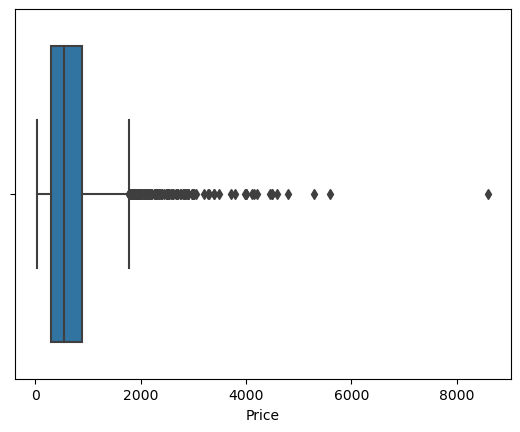

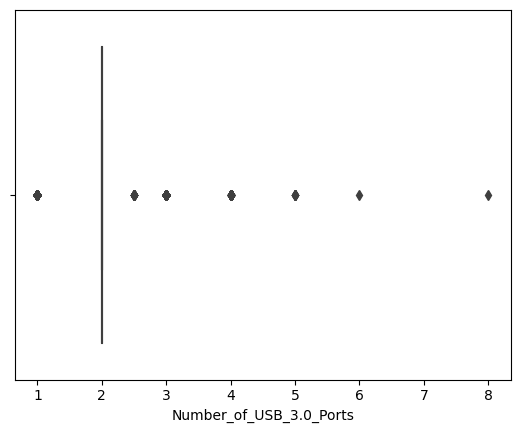

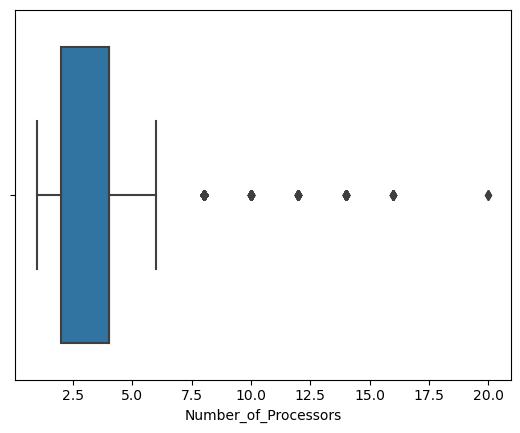

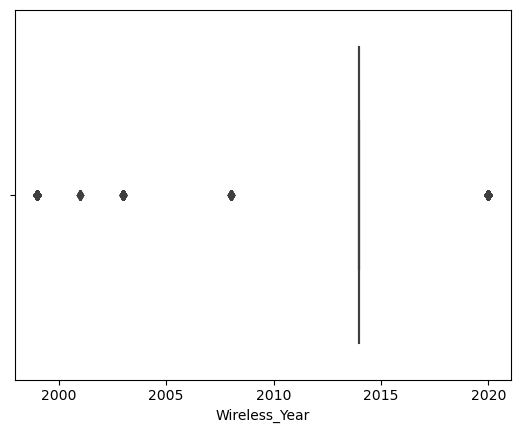

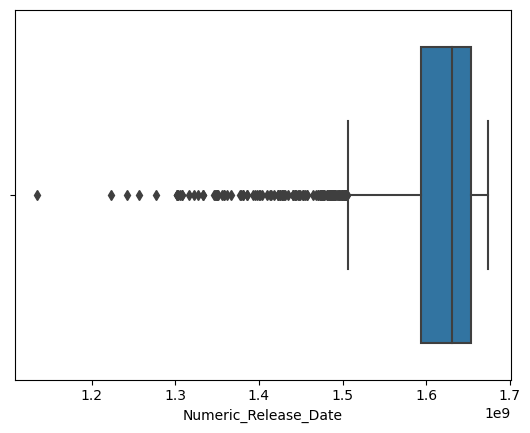

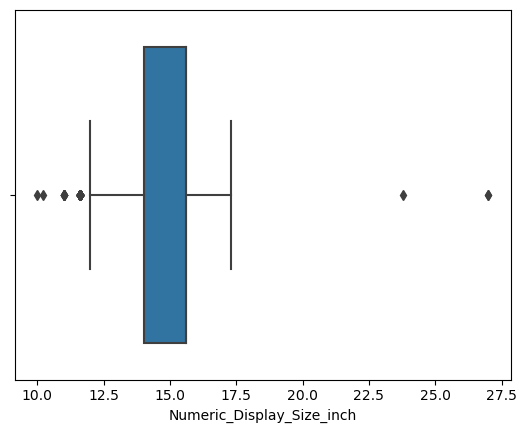

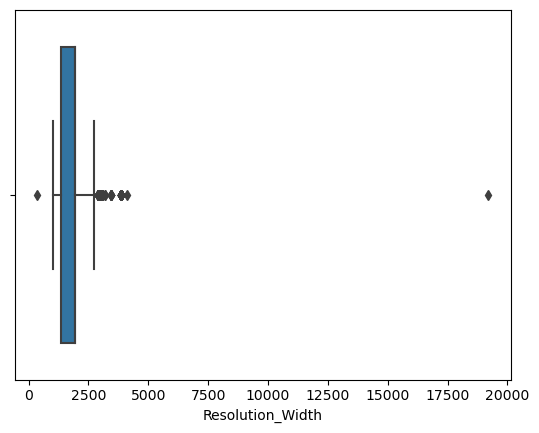

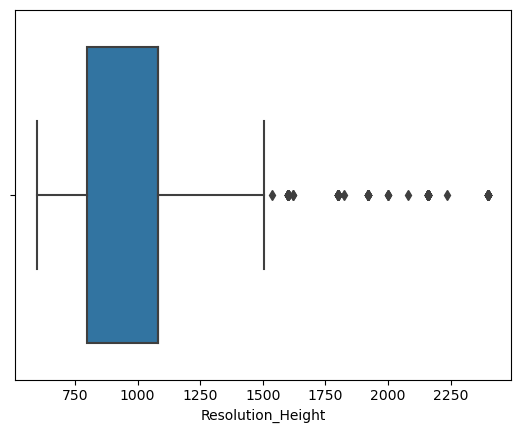

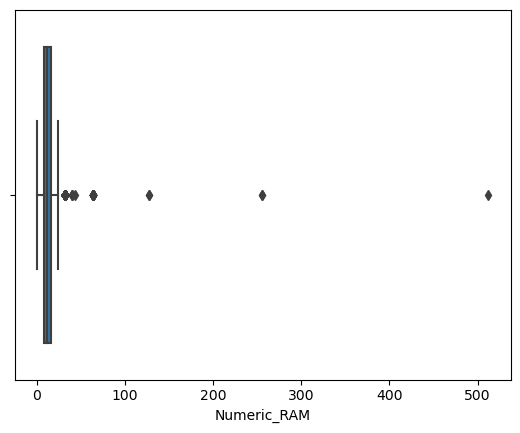

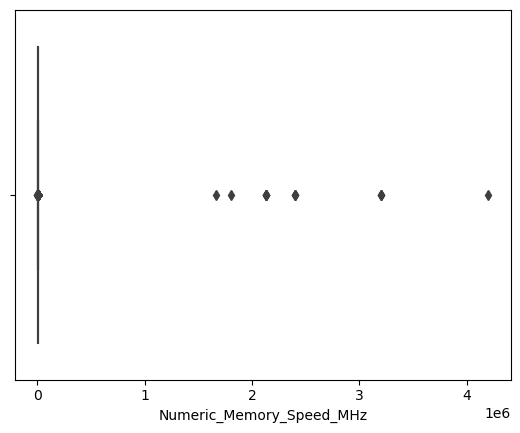

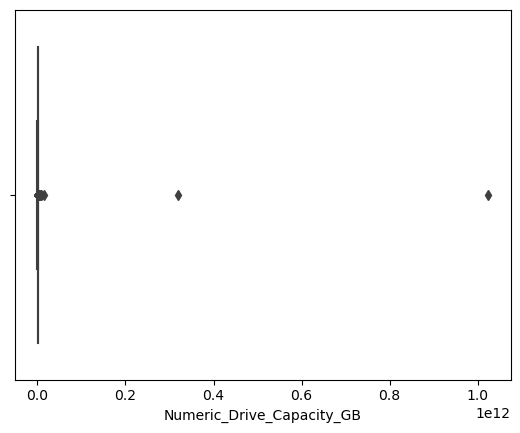

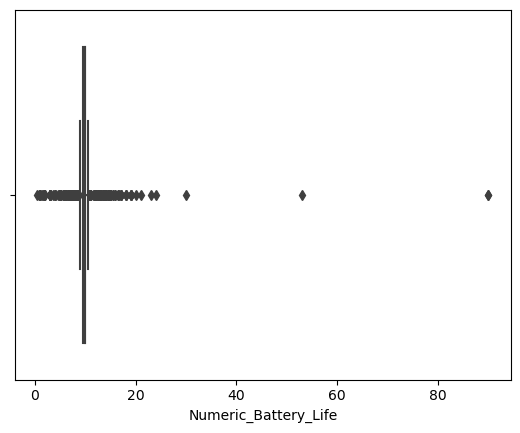

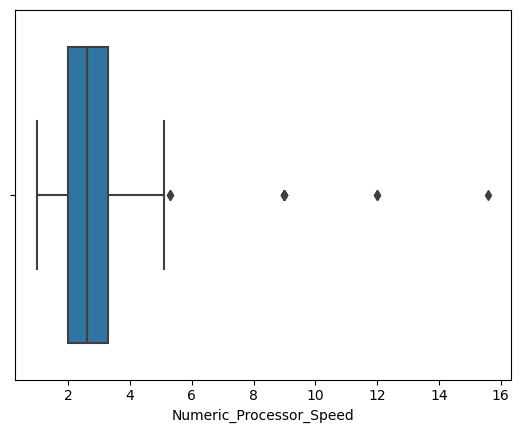

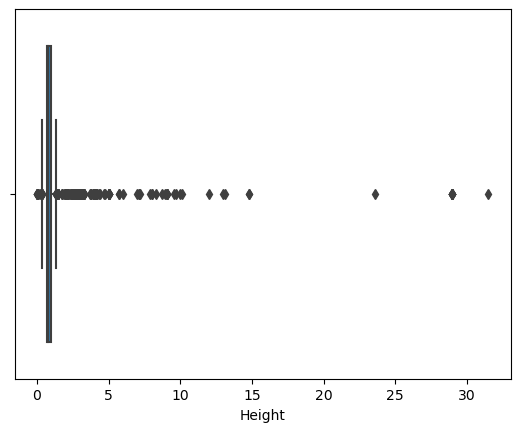

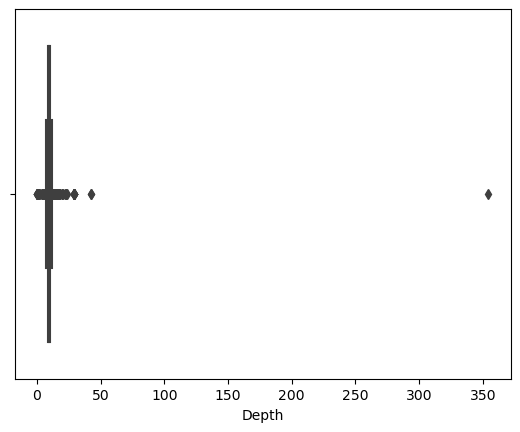

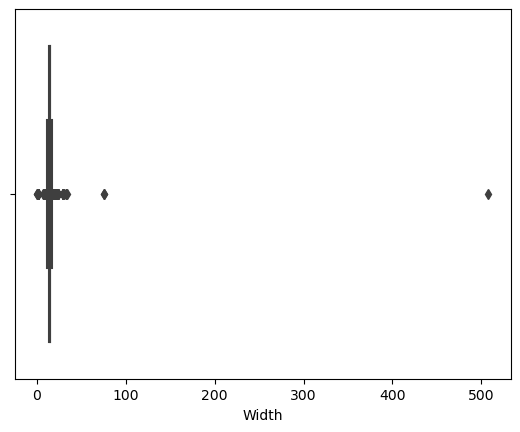

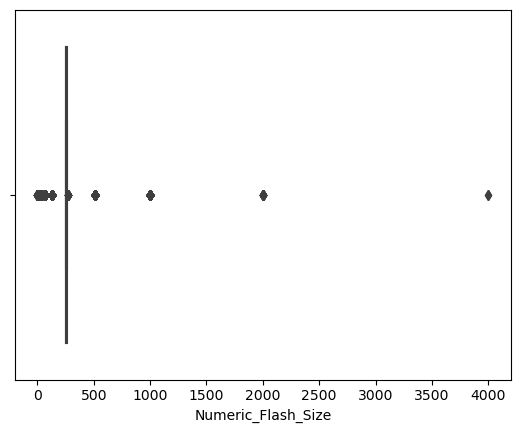

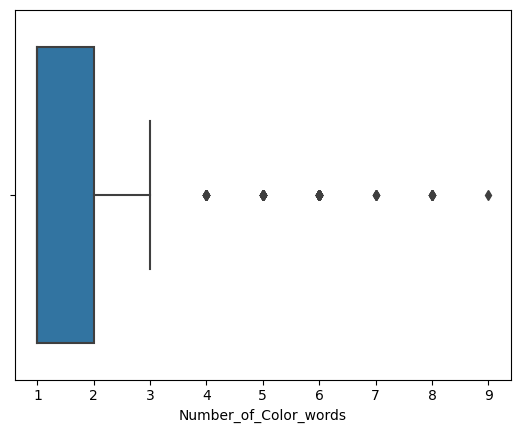

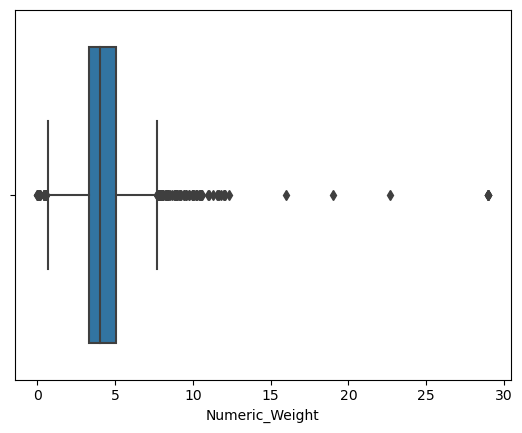

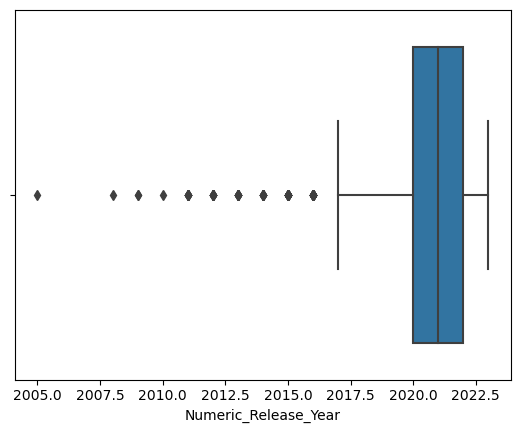

In [152]:
boxplot_numeric_col(df)

show of the boxplot can be ignorge if it's becuase it's chatgoracy like Year, number_of_color_words.
or there so many outliers that it means that that trait just has a big range like 'Numeric_Battery_Life'
but there are outliers in other cols, so we will go and use 

In [153]:
# df.columns

after going over each col in the reorgnizing part, I will use make a function for every col now<br>
(also was in a time crunch)
I used boxplot to see outliers so I will use IQR in the code<br>
in the coure (in 2023) we learned just to change outliers to NaN and than use the NaN we used again

In [154]:
def replace_outliers_with_NaN_in_col_IQR(df, lst):
    for col in df:
        if(col in lst and pd.api.types.is_numeric_dtype(df[col])):
            Q1 = np.nanpercentile(df[col], 25)
            Q3 = np.nanpercentile(df[col], 75)
            IQR = Q3 - Q1
            IQR_range = 1.5*IQR
            df.loc[(df[col] < Q1 - IQR_range) | (Q3 + IQR_range < df[col]), [col]] = np.nan
    return df

In [155]:
lst_col_outliers = ['Numeric_Display_Size_inch','Resolution_Width','Resolution_Height','Numeric_RAM',
                   'Numeric_Memory_Speed_MHz','Numeric_Drive_Capacity_GB','Numeric_Processor_Speed',
                   'Height','Depth','Width','Numeric_Weight','Numeric_Battery_Life']
df = replace_outliers_with_NaN_in_col_IQR(df, lst_col_outliers)

'Numeric_Flash_Size' isn't here becuse there's to much range (some are MB, GB and TB) which are organic<br>
so it will not go thoght outliers, (also beause it makes them all the same size 256GB, you can see it in the describe)

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             2580 non-null   object 
 1   Name                           2580 non-null   object 
 2   Price                          2580 non-null   float64
 3   Number_of_USB_3.0_Ports        2580 non-null   float64
 4   Number_of_Processors           2580 non-null   float64
 5   Computer_Memory_Type           2580 non-null   object 
 6   Hard_Drive_Interface           2580 non-null   object 
 7   Bluetooth                      2580 non-null   object 
 8   Wireless_Year                  2580 non-null   float64
 9   Numeric_Release_Date           2580 non-null   float64
 10  Numeric_Display_Size_inch      2426 non-null   float64
 11  Resolution_Width               2473 non-null   float64
 12  Resolution_Height              2435 non-null   f

In [157]:
df = fill_NaN_in_numeric_cols(df)

In [158]:
# df.info() # can un-comment to see, but the next line does the same and takes less space
print(df.isna().sum().sum())

0


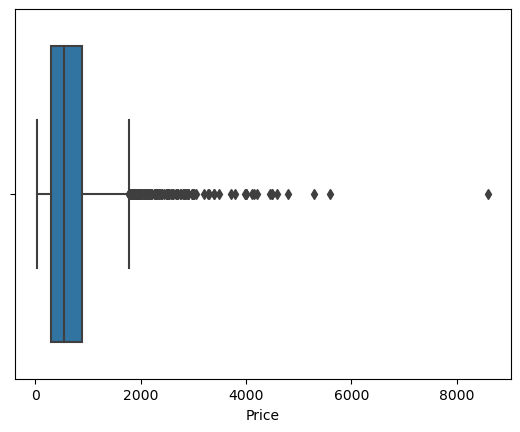

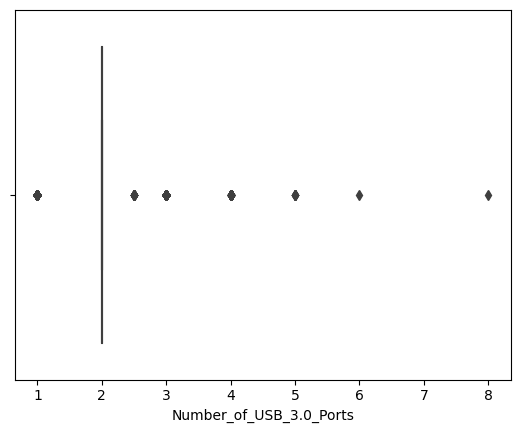

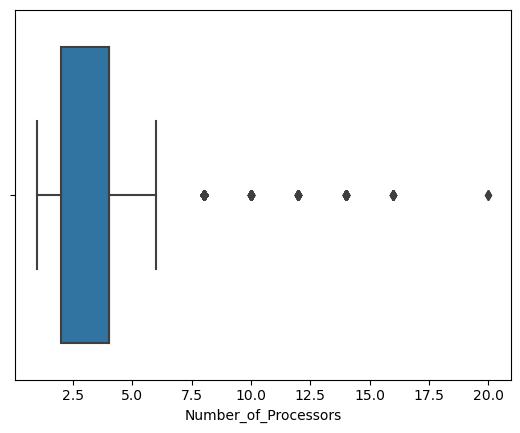

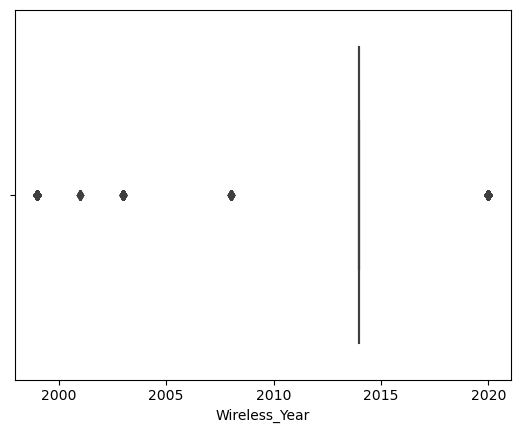

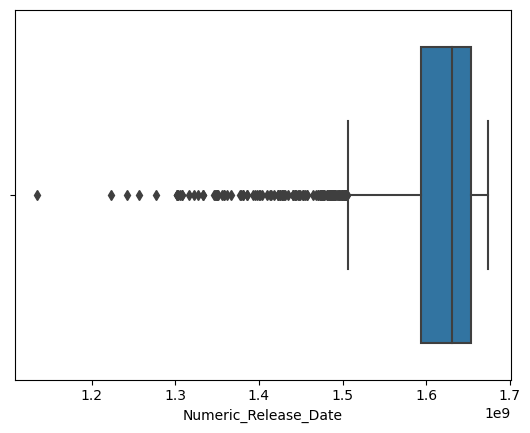

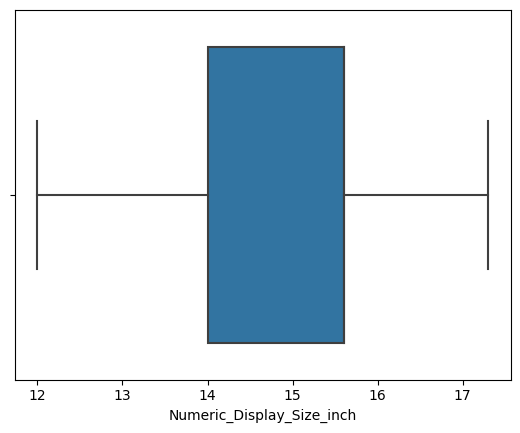

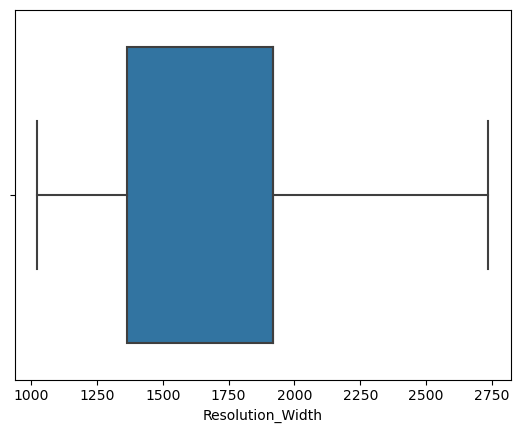

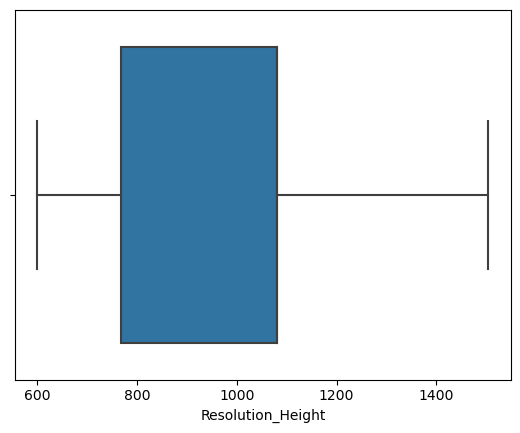

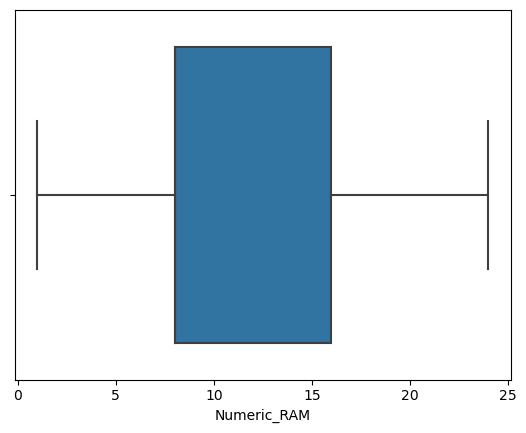

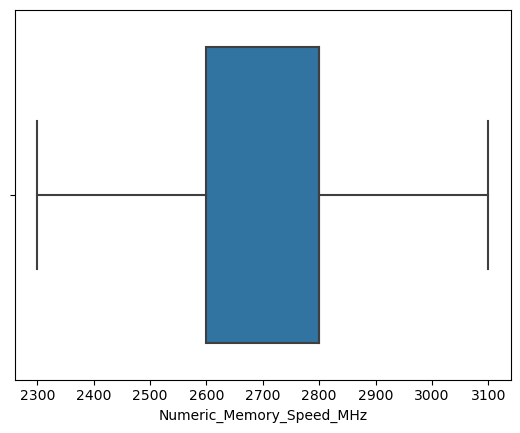

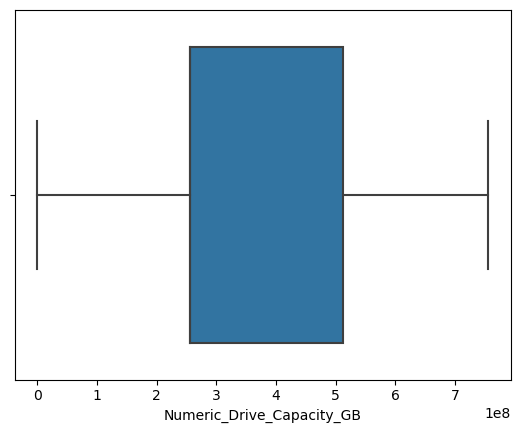

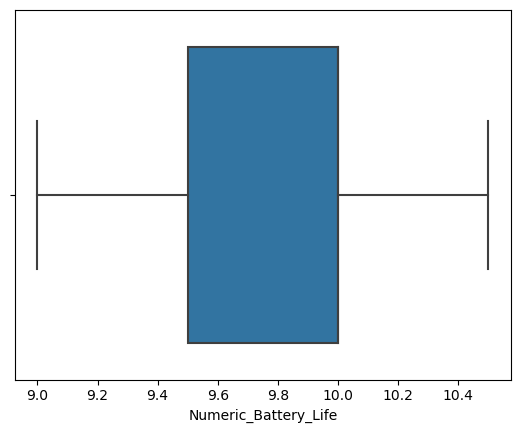

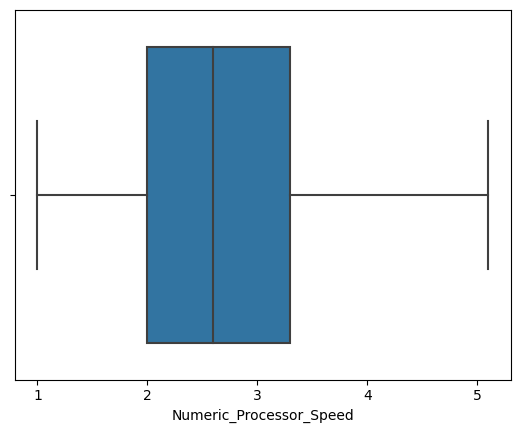

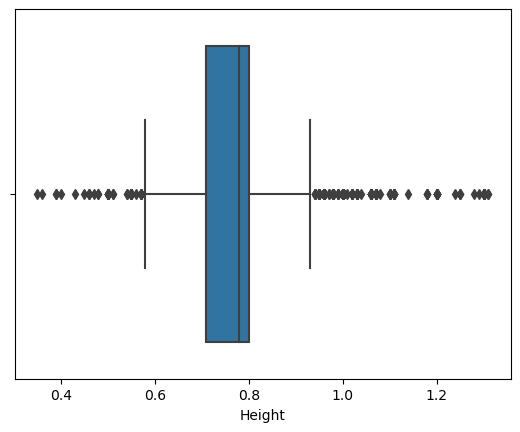

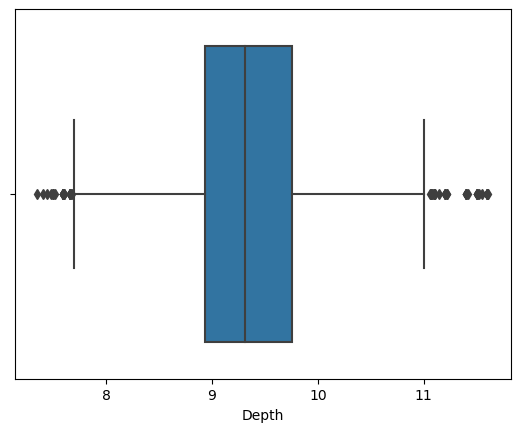

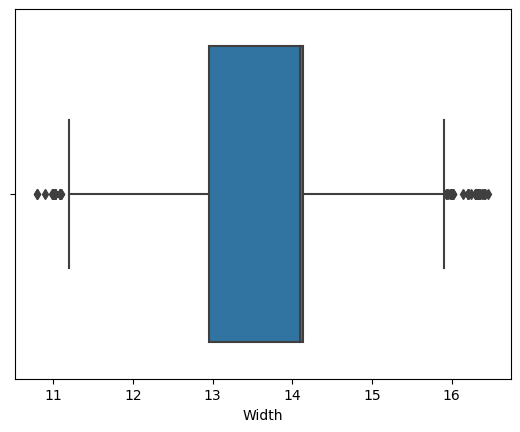

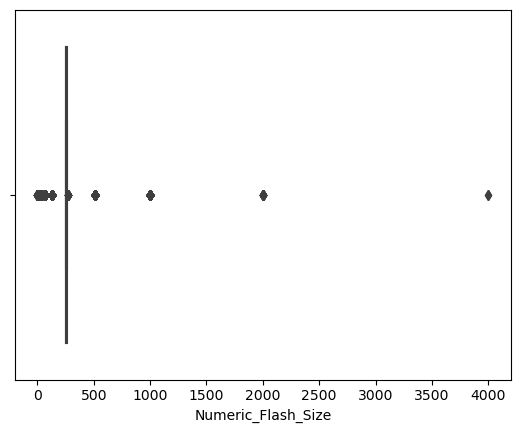

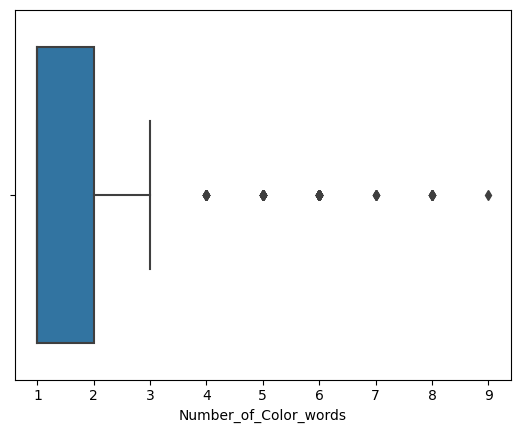

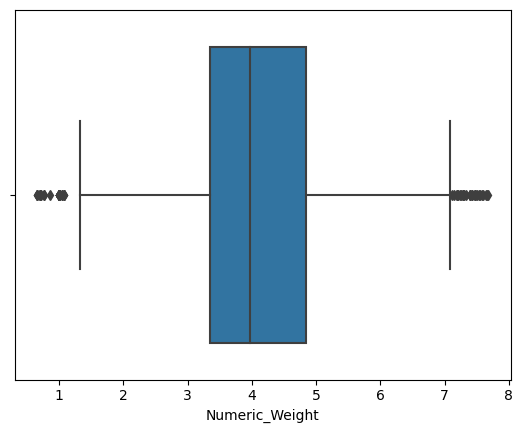

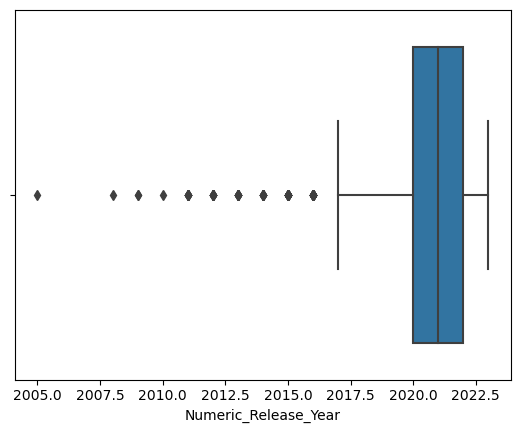

In [159]:
boxplot_numeric_col(df)

it might look like there are still outliers but that's because we are calculating the IQR again<br>
and there are changes, for exp look at 'Numeric_Weight' (it's close to the end of the boxplots)

In [160]:
df.describe()

,Price,Number_of_USB_3.0_Ports,Number_of_Processors,Wireless_Year,Numeric_Release_Date,Numeric_Display_Size_inch,Resolution_Width,Resolution_Height,Numeric_RAM,Numeric_Memory_Speed_MHz,Numeric_Drive_Capacity_GB,Numeric_Battery_Life,Numeric_Processor_Speed,Height,Depth,Width,Numeric_Flash_Size,Number_of_Color_words,Numeric_Weight,Numeric_Release_Year
count,2580.000000,2580.000000,2580.000000,2580.000000,2.580000e+03,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2.580000e+03,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.00000,2580.000000,2580.000000,2580.000000
mean,731.314453,2.127713,3.926938,2011.566667,1.613587e+09,15.035291,1777.908527,1000.911628,10.395736,2692.555814,3.376409e+08,9.829735,2.690148,0.789492,9.335909,13.776172,327.30680,1.418992,4.144856,2020.588372
std,657.088951,0.598780,2.885261,6.734410,5.891346e+07,1.130363,271.947729,148.990835,4.659019,154.350787,1.692522e+08,0.285364,1.041765,0.117821,0.710569,1.036797,302.53943,0.985759,1.150889,1.855674
min,44.000000,1.000000,1.000000,1999.000000,1.134950e+09,12.000000,1024.000000,600.000000,1.000000,2300.000000,1.280000e+02,9.000000,1.000000,0.350000,7.350000,10.800000,0.00000,1.000000,0.662500,2005.000000
25%,299.990000,2.000000,2.000000,2014.000000,1.594231e+09,14.000000,1366.000000,768.000000,8.000000,2600.000000,2.560000e+08,9.500000,2.000000,0.710000,8.930000,12.950000,256.00000,1.000000,3.350000,2020.000000
50%,549.990000,2.000000,4.000000,2014.000000,1.630454e+09,15.600000,1920.000000,1080.000000,8.000000,2800.000000,2.560000e+08,10.000000,2.600000,0.780000,9.310000,14.090000,256.00000,1.000000,3.970000,2021.000000
75%,890.247500,2.000000,4.000000,2014.000000,1.653350e+09,15.600000,1920.000000,1080.000000,16.000000,2800.000000,5.120000e+08,10.000000,3.300000,0.800000,9.760000,14.130000,260.00000,2.000000,4.850000,2022.000000
max,8599.000000,8.000000,20.000000,2020.000000,1.674346e+09,17.300000,2736.000000,1504.000000,24.000000,3100.000000,7.560000e+08,10.500000,5.100000,1.310000,11.610000,16.460000,4000.00000,9.000000,7.680000,2023.000000


it's understandeble to have 'outliers' in the boxplot show with 'Number_of_USB_3' and 'Number_of_Processors', <br>
becuase they are 0000<br>
but we see alot of 'outliers' in 'Numeric_Weight', thoues that are close (between 0 to 10) are fine,<br>
most laptops are diverss, a gaming laptop will be hevier then one for travel<br>
so for now lets check those who are 10 and up

there are all laptop, meaning the 'outliers' can orgnicly, so I will leave them.

other than that everything was gotten orgnicly so we can leave it be

In [161]:
# using this file in the next part
# df.to_csv('cleaned_data_final.csv', mode='x')

<span style=background:yellow>
    ---------------------------------------------------------------------------------------------------------------------
</span>

## <a class="anchor" id="eda_visualiztion"></a> Part 3 - EDA & Visualization

In [162]:
df = pd.read_csv('cleaned_data_final.csv')

In [163]:
df.describe()

,Unnamed: 0,Price,Number_of_USB_3.0_Ports,Number_of_Processors,Wireless_Year,Numeric_Release_Date,Numeric_Display_Size_inch,Resolution_Width,Resolution_Height,Numeric_RAM,...,Numeric_Drive_Capacity_GB,Numeric_Battery_Life,Numeric_Processor_Speed,Height,Depth,Width,Numeric_Flash_Size,Number_of_Color_words,Numeric_Weight,Numeric_Release_Year
count,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2.580000e+03,2580.000000,2580.000000,2580.000000,2580.000000,...,2.580000e+03,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.00000,2580.000000,2580.000000,2580.000000
mean,1289.500000,731.314453,2.127713,3.926938,2011.566667,1.613587e+09,15.035291,1777.908527,1000.911628,10.395736,...,3.376409e+08,9.829735,2.690148,0.789492,9.335909,13.776172,327.30680,1.418992,4.144856,2020.588372
std,744.926171,657.088951,0.598780,2.885261,6.734410,5.891346e+07,1.130363,271.947729,148.990835,4.659019,...,1.692522e+08,0.285364,1.041765,0.117821,0.710569,1.036797,302.53943,0.985759,1.150889,1.855674
min,0.000000,44.000000,1.000000,1.000000,1999.000000,1.134950e+09,12.000000,1024.000000,600.000000,1.000000,...,1.280000e+02,9.000000,1.000000,0.350000,7.350000,10.800000,0.00000,1.000000,0.662500,2005.000000
25%,644.750000,299.990000,2.000000,2.000000,2014.000000,1.594231e+09,14.000000,1366.000000,768.000000,8.000000,...,2.560000e+08,9.500000,2.000000,0.710000,8.930000,12.950000,256.00000,1.000000,3.350000,2020.000000
50%,1289.500000,549.990000,2.000000,4.000000,2014.000000,1.630454e+09,15.600000,1920.000000,1080.000000,8.000000,...,2.560000e+08,10.000000,2.600000,0.780000,9.310000,14.090000,256.00000,1.000000,3.970000,2021.000000
75%,1934.250000,890.247500,2.000000,4.000000,2014.000000,1.653350e+09,15.600000,1920.000000,1080.000000,16.000000,...,5.120000e+08,10.000000,3.300000,0.800000,9.760000,14.130000,260.00000,2.000000,4.850000,2022.000000
max,2579.000000,8599.000000,8.000000,20.000000,2020.000000,1.674346e+09,17.300000,2736.000000,1504.000000,24.000000,...,7.560000e+08,10.500000,5.100000,1.310000,11.610000,16.460000,4000.00000,9.000000,7.680000,2023.000000


in the Price col there's a 8600 prodoct and the second closest is 5000 so to not make the graphs strach, I made a new col<br>
its log10_price, the resan I use log10 and not logE is becouse it's simpler to clalculat 10^3 than e^3.

In [164]:
df['log10_price'] = df['Price'].map(np.log10)
df[['log10_price']].describe()

,log10_price
count,2580.000000
mean,2.729300
std,0.343527
min,1.643453
25%,2.477107
50%,2.740355
75%,2.949511
max,3.934448


now 8600$ is 3.934448,
the only thing the smaller prices (0 to 100) are close to one another

<AxesSubplot:>

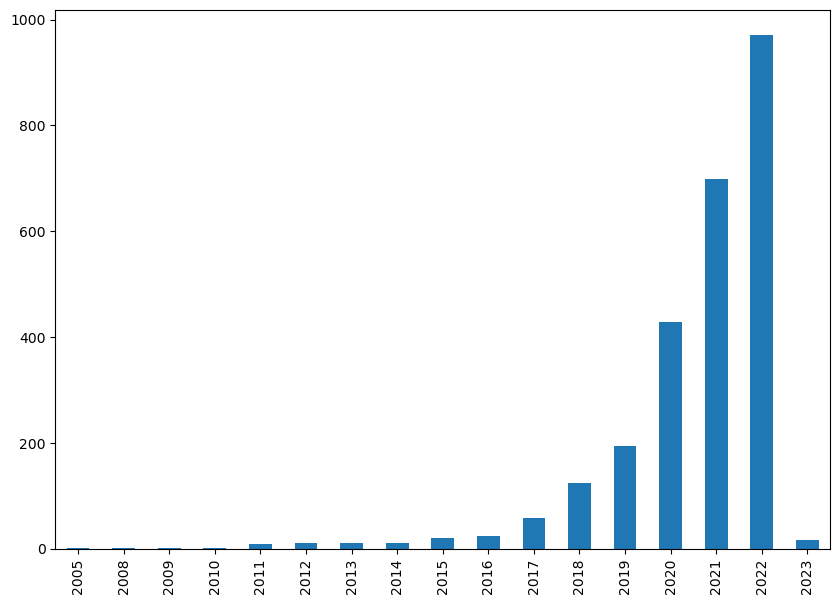

In [165]:
df.Numeric_Release_Year.value_counts().sort_index().plot(kind = 'bar', figsize=(10,7))

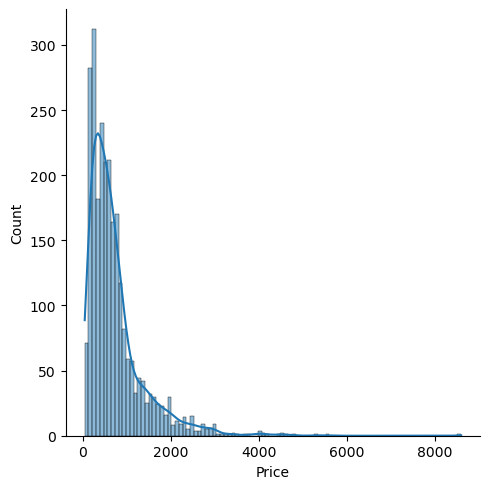

In [166]:
sns.displot(data=df['Price'], kde=True)

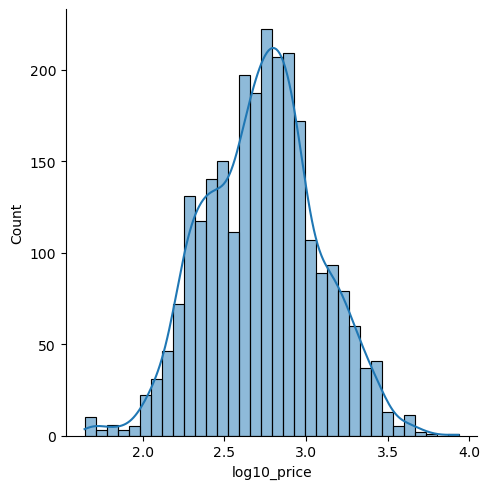

In [167]:
sns.displot(data=df['log10_price'], kde=True)

lets make a gratph for price to year

<AxesSubplot:xlabel='Date in sec', ylabel='Price'>

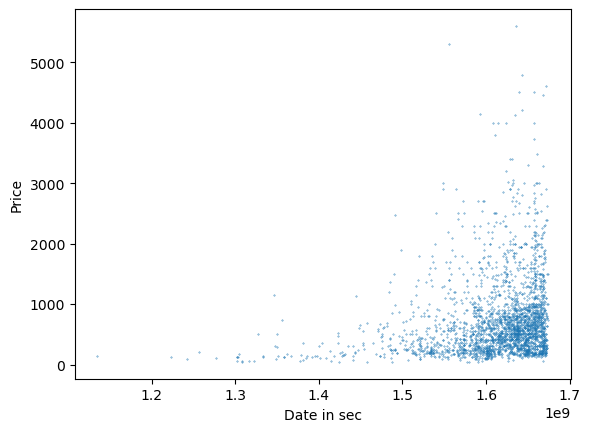

In [168]:
df_plot = df.copy()
df_plot = df_plot[df_plot['Price'] < 6000] #only has 1
df_plot[['Numeric_Release_Date','Price']].plot.scatter(x='Numeric_Release_Date',y='Price', s=0.1, xlabel = 'Date in sec')

<AxesSubplot:xlabel='Date in sec', ylabel='log10_price'>

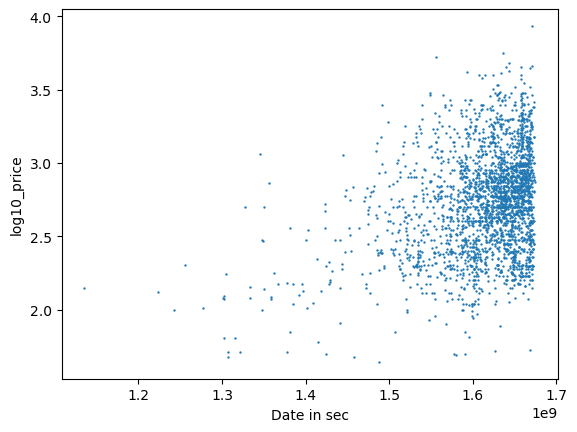

In [169]:
df_plot = df.copy()
df_plot[['Numeric_Release_Date','log10_price']].plot.scatter(x='Numeric_Release_Date',y='log10_price', 
                                                             s=0.5, xlabel = 'Date in sec')

3.0 is for 1000, 
2.5 is about 300, 
and 4.0 is 10000 

in the bolow graph you can see lines of points for every 100, like in 600 or 700,<br> that's why I made a graph with only 1500$ other ways the bigger prices make the lines unseeable

<AxesSubplot:xlabel='Date in sec', ylabel='Price'>

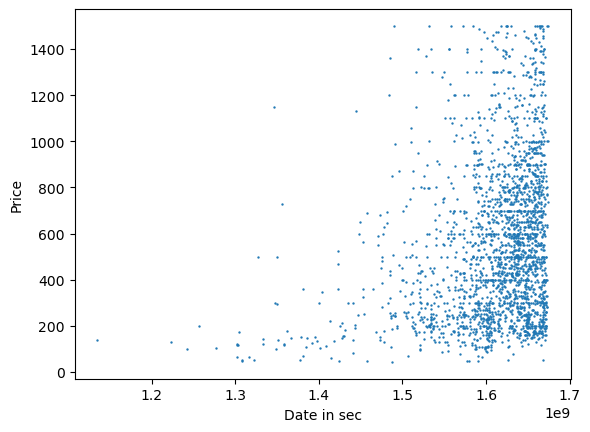

In [170]:
df_plot = df.copy()
df_plot = df_plot[df_plot['Price'] < 1500] #only has 1 
df_plot[['Numeric_Release_Date','Price']].plot.scatter(x='Numeric_Release_Date',y='Price', s=0.5, xlabel = 'Date in sec')

lets see how the price differc from brand to brand

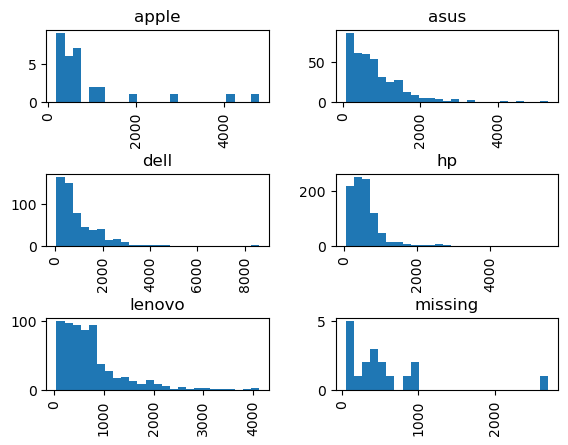

In [171]:
df_plot = df.copy()
df_plot = df_plot[df_plot.Clean_Brand != 'samsung'] #only has 1 
_ = df_plot['Price'].hist(by=df_plot['Clean_Brand'], bins = 25)
plt.subplots_adjust(hspace=1)

There isn't much data on apple to conclude anything.<br>
It seems that Lenovo is the chepies brand with most laptops in the range 0-1000 <br>
It also seems that HP and Dell are the more expensess brands, with Dell having the most expenseve laptop at 8600<br>
also most unbrand laptops are chepe which isn't suprising.

In [172]:
df_plot['Clean_Brand'].value_counts()

hp         928
lenovo     641
dell       568
asus       394
apple       30
missing     18
Name: Clean_Brand, dtype: int64

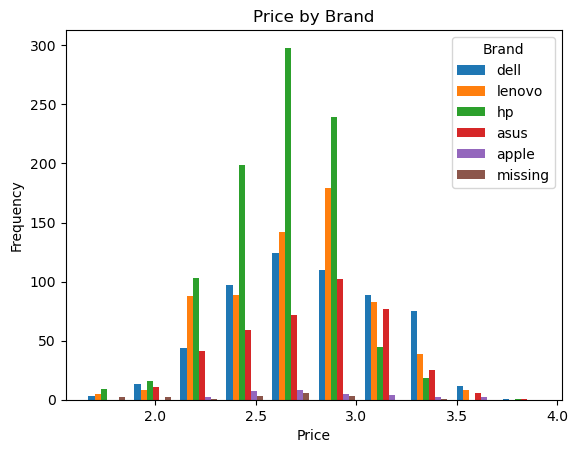

In [173]:
df_plot = df.copy()
df_plot = df_plot[df_plot.Clean_Brand != 'samsung'] #only has 1 
lst_hist = [df_plot['log10_price'][df_plot['Clean_Brand'] == brand] for brand in df_plot['Clean_Brand'].unique()]

plt.hist(lst_hist, bins = 10, label = df_plot['Clean_Brand'].unique())

plt.title('Price by Brand')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend(title='Brand')
plt.show()

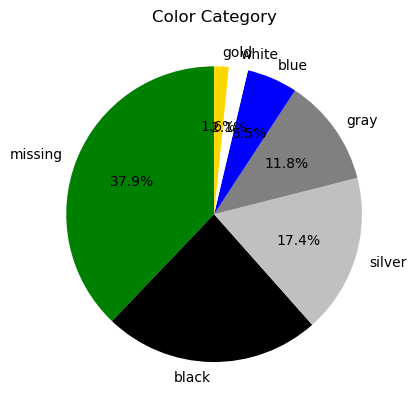

In [174]:
# for fun
color_counts = df['Color_Category'].value_counts()
labels = list(color_counts.index)
sizes = list(color_counts.values)
colors = list(color_counts.index)
colors.remove('missing')
colors.insert(0,'green') # choose green for 'missing' at random

plt.pie(sizes, labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')
plt.title('Color Category')
plt.show()

for fun I did one for colors, and missing is the bigest paice, I assume that most laptops come in one color so that trait wasn't in the prodoct page.

In [175]:
df = df.drop(['Unnamed: 0'], axis = 1)

Here's plots for every numeric col with log10_price

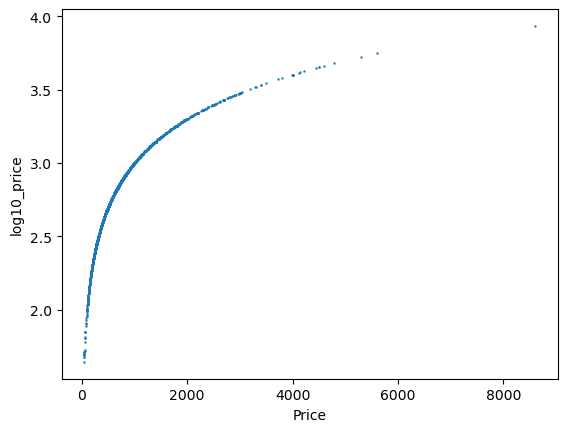

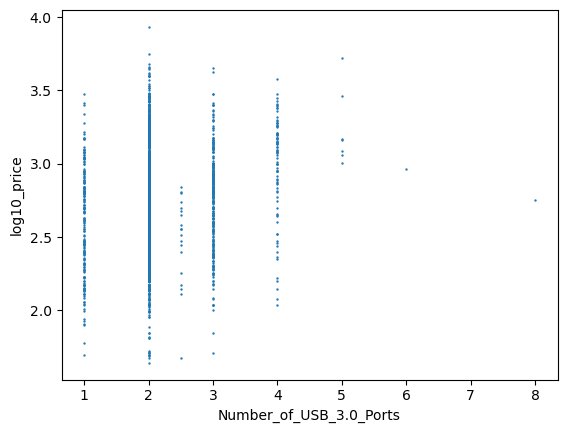

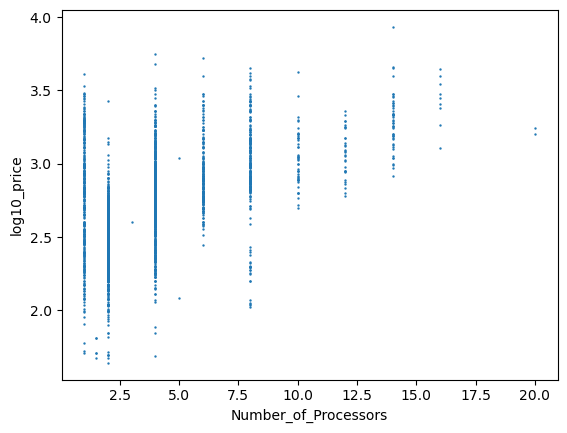

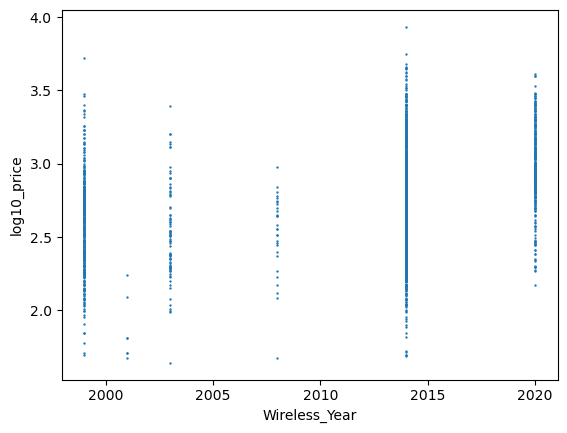

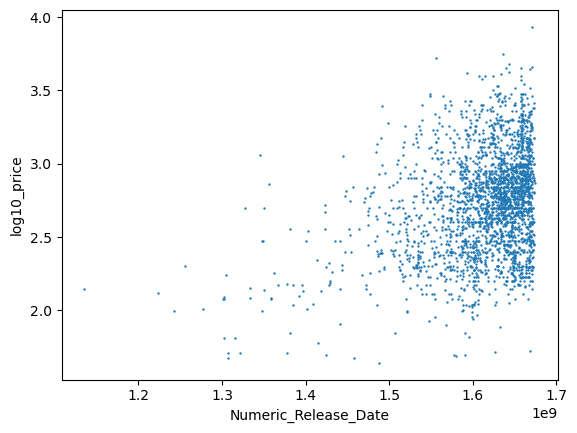

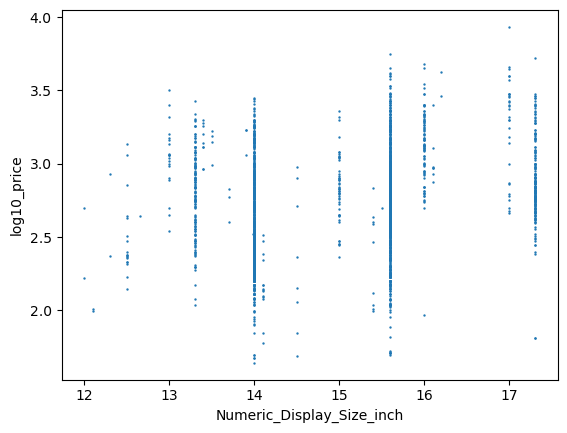

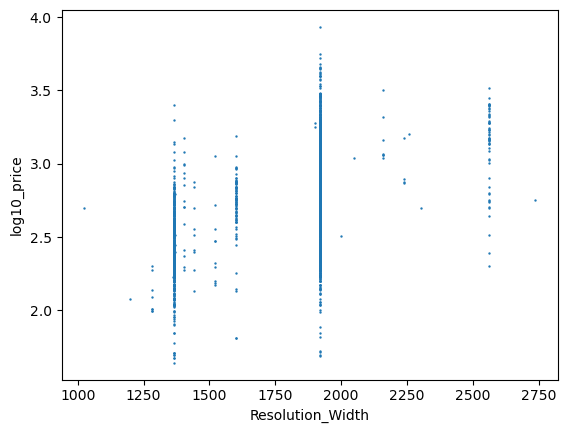

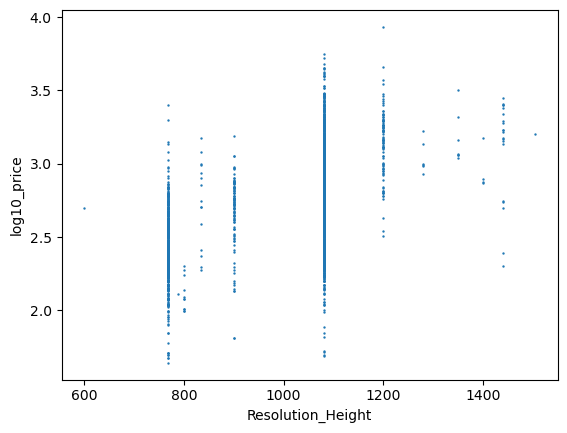

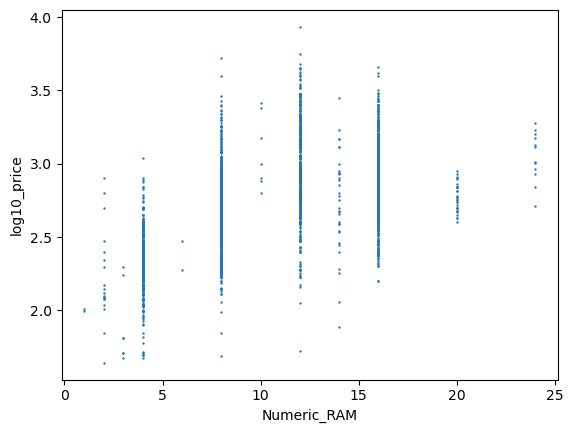

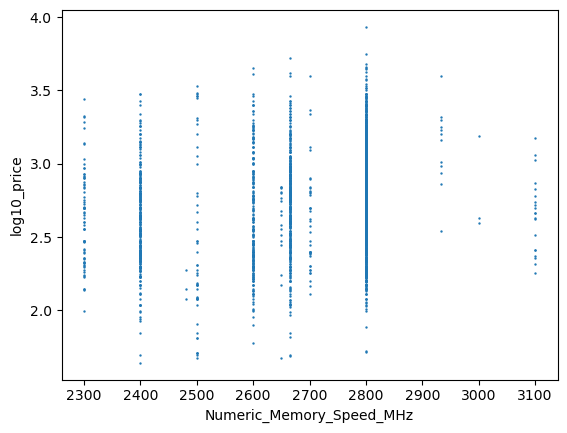

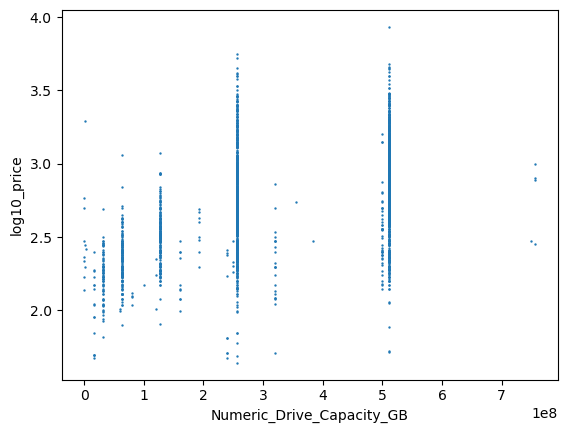

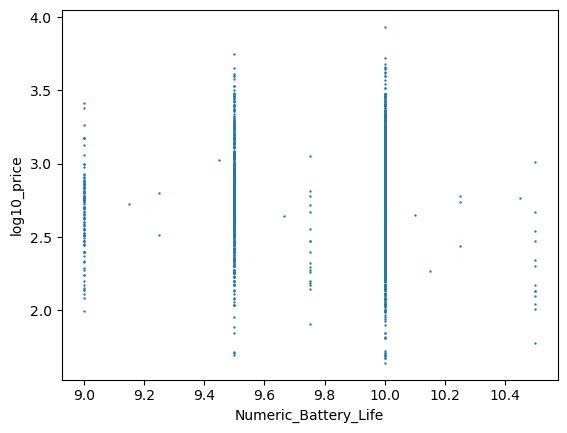

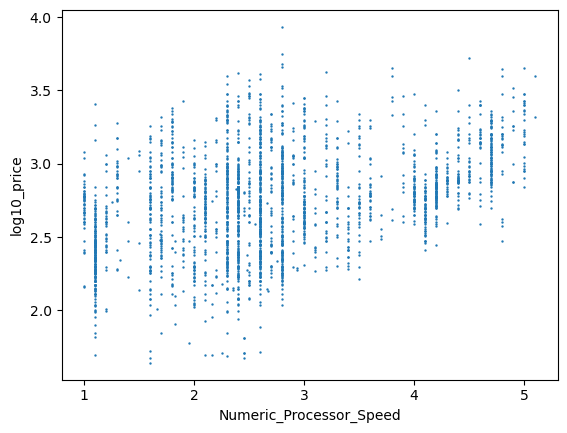

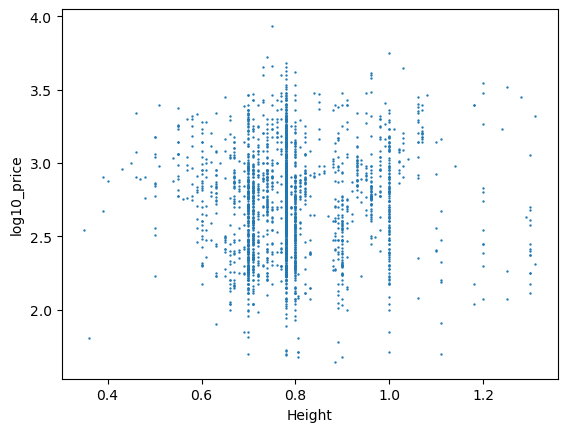

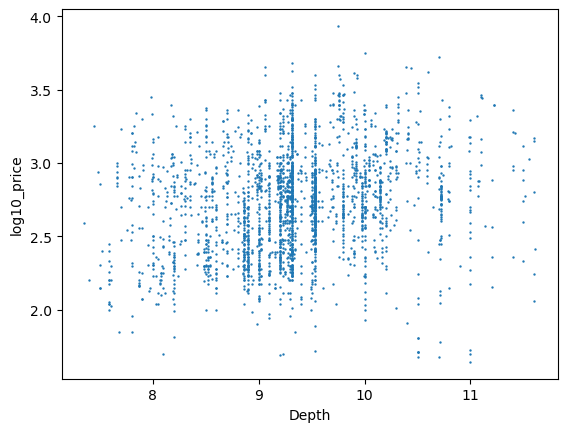

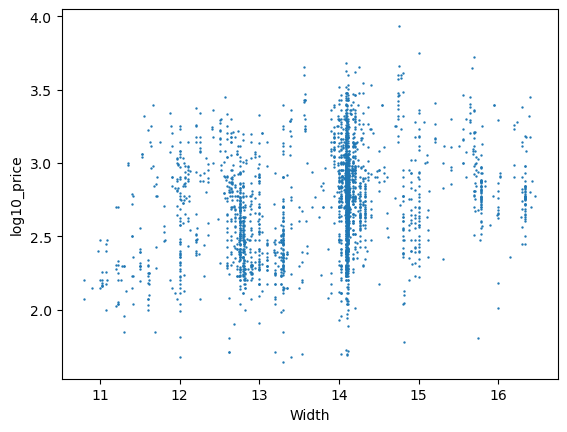

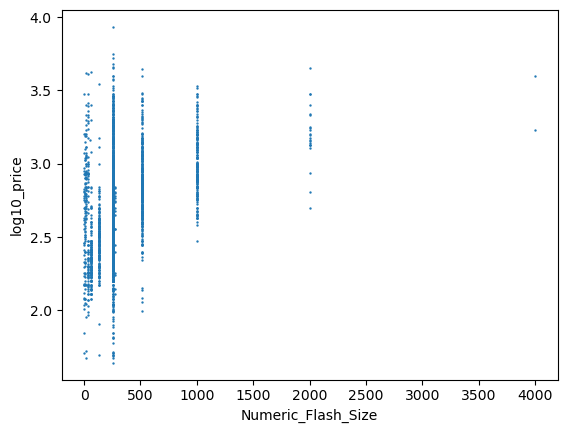

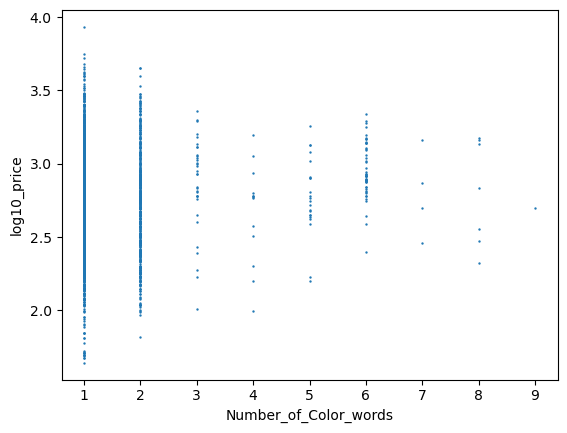

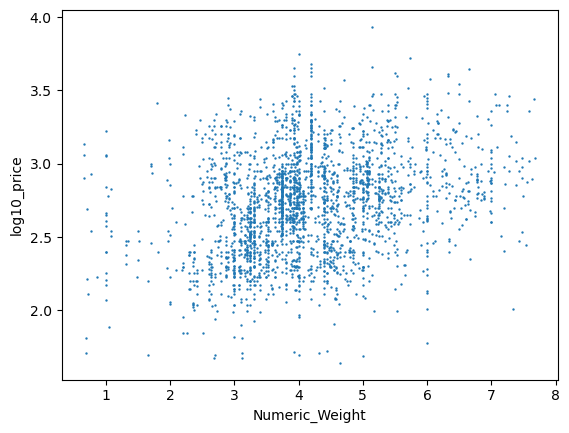

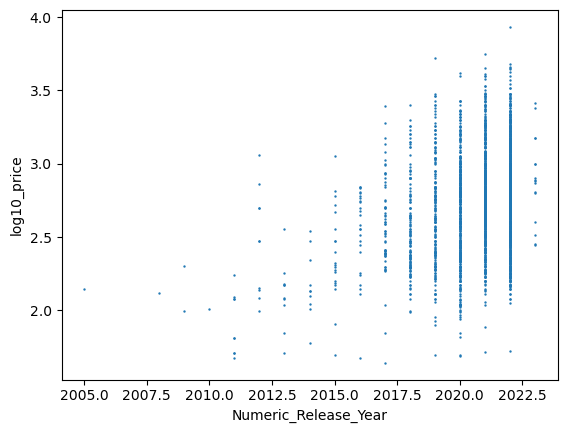

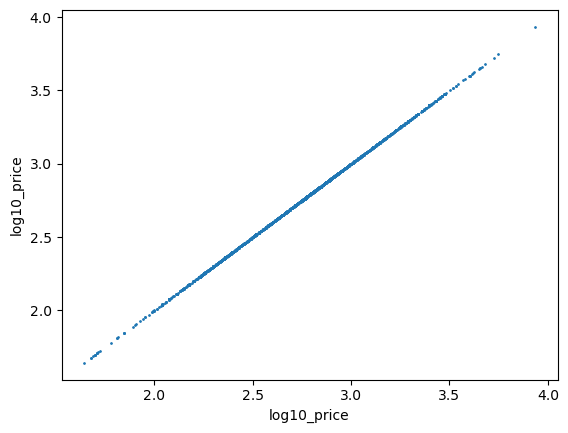

In [176]:
for col in df:
    if pd.api.types.is_numeric_dtype(df[col]):
        df_plot = df.copy()
        df_plot[[col,'log10_price']].plot.scatter(x=col,y='log10_price', s=0.5)

INFO I learn from the graphs:<br>



For some this show there isn't corolation with price:<br>
USB 3.0, Numeric_Memory_Speed_MHz, Numeric_Drive_Capacity_GB, Numeric_Battery_Life, Height and Depth (but not Width), Number_of_Color_words, Numeric_Weight.

For some we can see that there is coloration with price, mostly the bigger the number the higher the price:<br>
Number_of_Processors, Numeric_Release_Date, Numeric_Display_Size_inch, Resolution_Width and Height, RAM, Numeric_Processor_Speed, Width, Numeric_Flash_Size, Numeric_Release_Year.

Some of my thoghts:<br>
- Number_of_Color_words: <br>
I thought that the more words to discribe a color meant that there was branding or markting in volved that would make the price higher, but I got that wrong.<br>
- Height and Numeric_Weight: <br>
as of last couple of years the smaller of thiner a piace of tach was the more expansive, but is also makes true since laptops can be heavy with more RAM and bigger screens which make them heavyer. so they blance each other out<br>
- Width and Numeric_Display_Size_inch and Resolution_Width and Height: <br>
the bigger the screen the higher the price.<br>


<span style=background:yellow>
    ---------------------------------------------------------------------------------------------------------------------
</span>

## <a class="anchor" id="machine_learning"></a> Part 4 - Machine Learning

In [177]:
df = pd.read_csv('cleaned_data_final.csv')

In [178]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [179]:
# df.columns

before starting, I need to change all the data in df to numeric, because LinearRegression() doesn't accsep<br>
any thing that's not numeric

In [180]:
def change_all_to_Numeric(df):
    df_temp = df.copy()
    le = LabelEncoder()
    categorical_cols = df_temp.select_dtypes(include = 'object').columns
    df_temp[categorical_cols] = df_temp[categorical_cols].apply(lambda col: le.fit_transform(col))
    return df_temp

I looked at my homework and copyed alot of it (with miner changes)

In [181]:
# dataset (data frame): is df with the label_column 
# label_column (string): name of col with want to learn, also the col that will be remove from dataset
def split_to_train_and_test(dataset, label_column, test_ratio = 0.2, rand_state = 42):
    
    col_index = dataset.columns.get_loc(label_column)
    y = dataset.iloc[:,col_index]
    X = dataset.drop(label_column, inplace=False, axis=1)
    
    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ratio, random_state = rand_state)
    
    return X_train, X_test, y_train, y_test

In [182]:
def train_model(X_train, y_train):
    trained_model = LinearRegression().fit(X_train, y_train)
    return trained_model

In [183]:
def predict_train_model(trained_1st_model, X_test):
    res = trained_1st_model.predict(X_test)
    return res

In [184]:
def evaluate_performance_1st(y_test, y_predicted):
    r2 = metrics.r2_score(y_test, y_predicted)
    evaluate_value = r2
    return evaluate_value

In [185]:
def all_in_one_split_train_predict_evaluate(df, col_name = 'Price'):
    # spilt
    X_train, X_test, y_train, y_test = split_to_train_and_test(dataset = df_ML, label_column = col_name, 
                                                               test_ratio = 0.2, rand_state = 42)
    # train
    trained_model = train_model(X_train, y_train)
    # predict
    y_predicted = predict_train_model(trained_model, X_test)
    # evaluate
    evaluate_value = evaluate_performance_1st(y_test, y_predicted)
    return evaluate_value

In [186]:
df_ML = df.copy()

# all to numierc
df_ML = change_all_to_Numeric(df_ML)

evaluate_value =  all_in_one_split_train_predict_evaluate(df_ML, col_name = 'Price')

print(evaluate_value)

0.4977790984252516


0.49 is pretty good for not doing any mager changes to the data,<br>
I tried to improve it with a couple of ways, but they didn't improve the R2<br>
So I tried to see what would happen if the Price col was in log10, like I did in the graphs<br>
and as you will see it improved the R2

NOTE: with change_all_to_Numeric and log10_price: evaluate_value = 0.6534284155018321

In [187]:
df_ML = df.copy()
# all to numierc
df_ML = change_all_to_Numeric(df_ML)

# change the price col
df_ML['log10_price'] = df_ML['Price'].map(np.log10)
df_ML = df_ML.drop(['Price'], axis = 1)

evaluate_value =  all_in_one_split_train_predict_evaluate(df_ML, col_name = 'log10_price')
print(evaluate_value)

0.6534284155018321


NOTE: when getting rid of all 'object' cols we get: evaluate_value = 0.34332850930881376

In [188]:
# droping all object cols
df_ML = df.copy()
df_ML = df_ML.select_dtypes(exclude=['object'])

evaluate_value =  all_in_one_split_train_predict_evaluate(df_ML, col_name = 'Price')
print(evaluate_value)

0.34332850930881376


NOTE: with change_all_to_Numeric and without ID, Name cols: evaluate_value = 0.49347013942471807

In [189]:
# droping ID, Name
df_ML = df.copy()
df_ML = change_all_to_Numeric(df_ML)
df_ML = df_ML.drop(['ID'], axis = 1)
df_ML = df_ML.drop(['Name'], axis = 1)

evaluate_value =  all_in_one_split_train_predict_evaluate(df_ML, col_name = 'Price')
print(evaluate_value)

0.49347013942471807
